In [1]:
import xarray as xr
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")

# Extract latitude, longitude, and u10 variables
lat = climatology['latitude'].values
lon = climatology['longitude'].values
climatology_u10 = climatology['z'].values  # Extract raw values
dust_event_u10 = dust_event['z'].values  # Extract raw values

# Ensure the variables are 2D by checking dimensions
if climatology_u10.ndim == 3:
    climatology_u10 = climatology_u10[0, :, :]  # Squeeze time dimension if present
if dust_event_u10.ndim == 3:
    dust_event_u10 = dust_event_u10[0, :, :]  # Squeeze time dimension if present

# Restrict data to the specific coordinates
lon_mask = (lon >= -150) & (lon <= -60)  # Longitude range
lat_mask = (lat >= 20) & (lat <= 50)  # Latitude range

lon_restricted = lon[lon_mask]  # Slice longitude
lat_restricted = lat[lat_mask]  # Slice latitude

climatology_u10_restricted = climatology_u10[lat_mask, :][:, lon_mask]
dust_event_u10_restricted = dust_event_u10[lat_mask, :][:, lon_mask]

# Compute anomalies: Dust event minus climatology
anomalies_restricted = dust_event_u10_restricted - climatology_u10_restricted

# Perform a t-test for statistical significance
t_stat, p_values = ttest_ind(dust_event_u10_restricted[np.newaxis, :, :],
                             climatology_u10_restricted[np.newaxis, :, :],
                             axis=0, equal_var=False, nan_policy='omit')

# Define significance level
significance_level = 0.05
significant_mask = p_values < significance_level

# Create a meshgrid for the restricted region
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)

# Plot the composite anomalies with statistical significance
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))
ax.set_extent([-150, -60, 20, 50], crs=ccrs.PlateCarree())  # Adjust the extent to the specific coordinates

# Plot anomalies
anomaly_plot = ax.contourf(lon2d, lat2d, anomalies_restricted, levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())

# Overlay significant areas
ax.contourf(lon2d, lat2d, significant_mask.astype(int), levels=[0.5, 1], colors='none', hatches=['..'], transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')  # Add country borders
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')


# Add California and Central Valley shapefiles
california_shapefile = "california_shapefile.shp"  # Replace with the path to the shapefile
central_valley_shapefile = "central_valley_counties.shp"  # Replace with the path to the shapefile

# Add California counties
california_feature = ShapelyFeature(Reader(california_shapefile).geometries(),
                                    ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linewidth=1)
ax.add_feature(california_feature, label="California Counties")

# Add Central Valley
central_valley_feature = ShapelyFeature(Reader(central_valley_shapefile).geometries(),
                                        ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.5)
ax.add_feature(central_valley_feature, label="Central Valley")


# Add gridlines with labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gridlines.top_labels = False  # Turn off the labels on the top
gridlines.right_labels = False  # Turn off the labels on the right
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

# Add title and colorbar
ax.set_title("Composite Anomalies of Dust Events (u10) for Specific Region")
cbar = fig.colorbar(anomaly_plot, ax=ax, orientation='horizontal', pad=0.05, label="u10 (m/s) Anomaly")

plt.show()


/home/precious/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1567 but corresponding boolean dimension is 201

/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


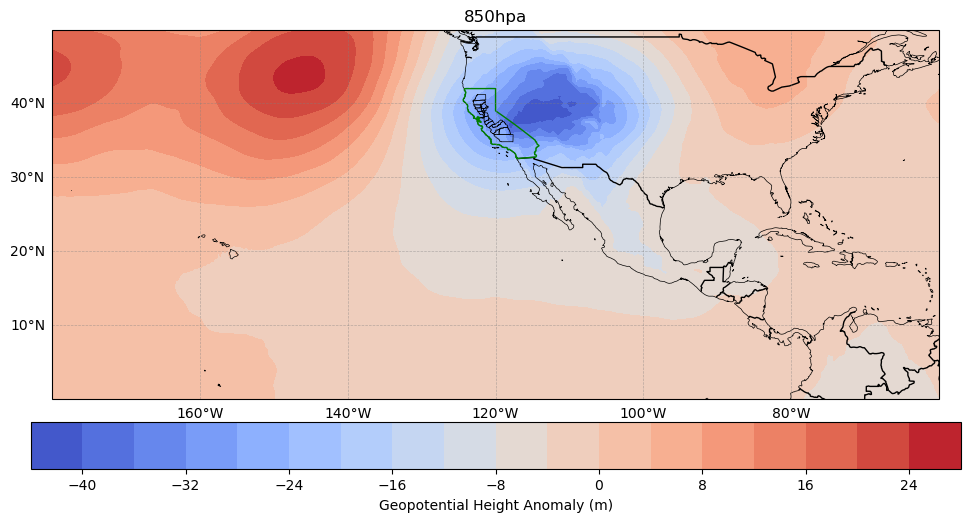

In [51]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from scipy.stats import ttest_ind

# Load the datasets
climatology = xr.open_dataset("clim.nc")  # Climatology dataset
dust_event = xr.open_dataset("dust-composite2.nc")  # Dust event data

# Adjust dimension names if necessary (e.g., rename valid_time to time)
if 'valid_time' in climatology.dims:
    climatology = climatology.rename({'valid_time': 'time'})
if 'valid_time' in dust_event.dims:
    dust_event = dust_event.rename({'valid_time': 'time'})

# Calculate anomalies for the dust event dates
anomalies = (dust_event/9.8) - (climatology/9.8)  # Subtract climatology from dust event data

# Take the mean of the anomalies across all dust event time steps
mean_anomalies = anomalies.mean(dim="time")

# Extract latitude and longitude
lat = climatology['latitude'].values
lon = climatology['longitude'].values

# Restrict data to specific coordinates
lon_mask = (lon >= -180) & (lon <= -60)  # Longitude range
lat_mask = (lat >= 0) & (lat <= 50)  # Latitude range

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

mean_anomalies_restricted = mean_anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Reduce the 3D anomalies to 2D by selecting or averaging over the pressure_level
if 'pressure_level' in mean_anomalies_restricted.dims:
    mean_anomalies_2d = mean_anomalies_restricted['z'].mean(dim='pressure_level')  # Average over pressure_level
else:
    mean_anomalies_2d = mean_anomalies_restricted['z']  # If no pressure_level, keep as is

# Perform a t-test for statistical significance
t_stat, p_values = ttest_ind(
    dust_event['z'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='pressure_level').values,
    climatology['z'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='pressure_level').values,
    axis=0,
    equal_var=False,
    nan_policy='omit'
)

# Define significance level
significance_level = 0.05
significant_mask = p_values < significance_level

# Ensure significant_mask is 2D
if significant_mask.ndim == 3:  # Reduce dimensionality if needed
    significant_mask_2d = significant_mask.mean(axis=0)
else:
    significant_mask_2d = significant_mask

# Create a meshgrid for the restricted region
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)

# Plot the composite anomalies
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))
ax.set_extent([-180, -60, 0, 50], crs=ccrs.PlateCarree())

# Plot anomalies (2D array)
anomaly_plot = ax.contourf(
    lon2d,
    lat2d,
    mean_anomalies_2d,
    levels=20,
    cmap='coolwarm',
    transform=ccrs.PlateCarree(),
)

# Overlay significant areas
ax.contourf(
    lon2d,
    lat2d,
    significant_mask_2d.astype(int),
    levels=[0.5, 1],
    colors='none',
    hatches=['..'],
    transform=ccrs.PlateCarree(),
)

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add California and Central Valley shapefiles
california_shapefile = "california_shapefile.shp"  # Replace with the path to the shapefile
central_valley_shapefile = "central_valley_counties.shp"  # Replace with the path to the shapefile

california_feature = ShapelyFeature(
    Reader(california_shapefile).geometries(),
    ccrs.PlateCarree(),
    edgecolor='green',
    facecolor='none',
    linewidth=1,
)
ax.add_feature(california_feature)

central_valley_feature = ShapelyFeature(
    Reader(central_valley_shapefile).geometries(),
    ccrs.PlateCarree(),
    edgecolor='black',
    facecolor='none',
    linewidth=0.5,
)
ax.add_feature(central_valley_feature)

# Add gridlines with labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

# Add title and colorbar
ax.set_title("850hpa")
cbar = fig.colorbar(anomaly_plot, ax=ax, orientation='horizontal', pad=0.05, label="Geopotential Height Anomaly (m)")

plt.savefig("850hpa_anomalie2.png", dpi=300, bbox_inches='tight')

plt.show()


lon_quiver shape: (14, 33)
lat_quiver shape: (14, 33)
u_quiver shape: (14, 33)
v_quiver shape: (14, 33)


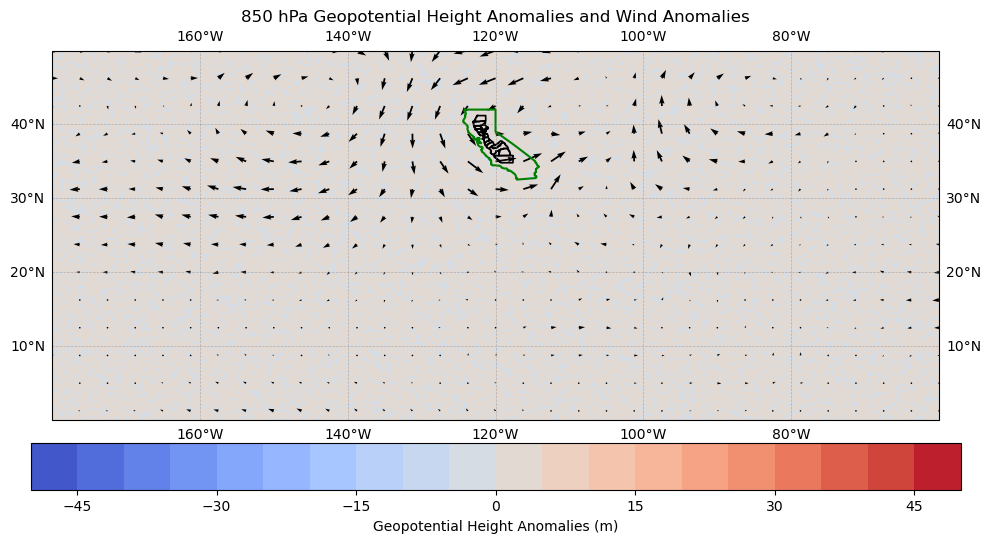

In [57]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u_dust = xr.open_dataset("u850_dust.nc")
u_clim = xr.open_dataset("u_clim.nc")
v_dust = xr.open_dataset("v850_dust.nc")
v_clim = xr.open_dataset("v_clim.nc")

# Calculate geopotential height anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict data to specific latitude and longitude bounds
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)
lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]
anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare anomalies for plotting (2D: lat, lon)
data = anomalies_restricted['z']
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')
time_mean = data.mean(dim='valid_time')
composite_anomalies = data - time_mean
composite_anomalies = composite_anomalies.mean(dim='valid_time')  # Final 2D anomalies

# Calculate wind anomalies
u_anomalies = (u_dust['u'] - u_clim['u']).sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')
v_anomalies = (v_dust['v'] - v_clim['v']).sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')

# Sparsify data for quiver plot
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)
quiver_spacing = 15
lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]
u_quiver = u_anomalies.values.squeeze()[::quiver_spacing, ::quiver_spacing]
v_quiver = v_anomalies.values.squeeze()[::quiver_spacing, ::quiver_spacing]

# Ensure shapes match
print(f"lon_quiver shape: {lon_quiver.shape}")
print(f"lat_quiver shape: {lat_quiver.shape}")
print(f"u_quiver shape: {u_quiver.shape}")
print(f"v_quiver shape: {v_quiver.shape}")

assert lon_quiver.shape == u_quiver.shape, "Longitude grid and U data shape mismatch"
assert lat_quiver.shape == v_quiver.shape, "Latitude grid and V data shape mismatch"

# Define shapefiles
california_shapefile = "california_shapefile.shp"
central_valley_shapefile = "central_valley_counties.shp"

# Plot composite anomalies and wind vectors
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, -60, 0, 50], crs=ccrs.PlateCarree())

# Plot geopotential height anomalies
contour = ax.contourf(
    lon2d, lat2d, composite_anomalies,
    levels=np.linspace(-50, 50, 21),
    cmap='coolwarm',
    transform=ccrs.PlateCarree()
)

# Add wind vectors
ax.quiver(
    lon_quiver, lat_quiver, u_quiver, v_quiver,
    scale=200, width=0.002, color='black', transform=ccrs.PlateCarree()
)

# Add California and Central Valley shapefiles
ax.add_feature(
    ShapelyFeature(
        Reader(california_shapefile).geometries(),
        ccrs.PlateCarree(),
        edgecolor='green',
        facecolor='none',
        linewidth=1.5
    )
)
ax.add_feature(
    ShapelyFeature(
        Reader(central_valley_shapefile).geometries(),
        ccrs.PlateCarree(),
        edgecolor='black',
        facecolor='none',
        linewidth=1.2
    )
)

# Add gridlines and title
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax.set_title("850 hPa Geopotential Height Anomalies and Wind Anomalies")
cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, label="Geopotential Height Anomalies (m)")
plt.savefig("composite_anomalies_with_wind_vectors_no_significance.png", dpi=300, bbox_inches='tight')
plt.show()


lon_quiver shape: (14, 33)
lat_quiver shape: (14, 33)
u_quiver shape: (14, 33)
v_quiver shape: (14, 33)


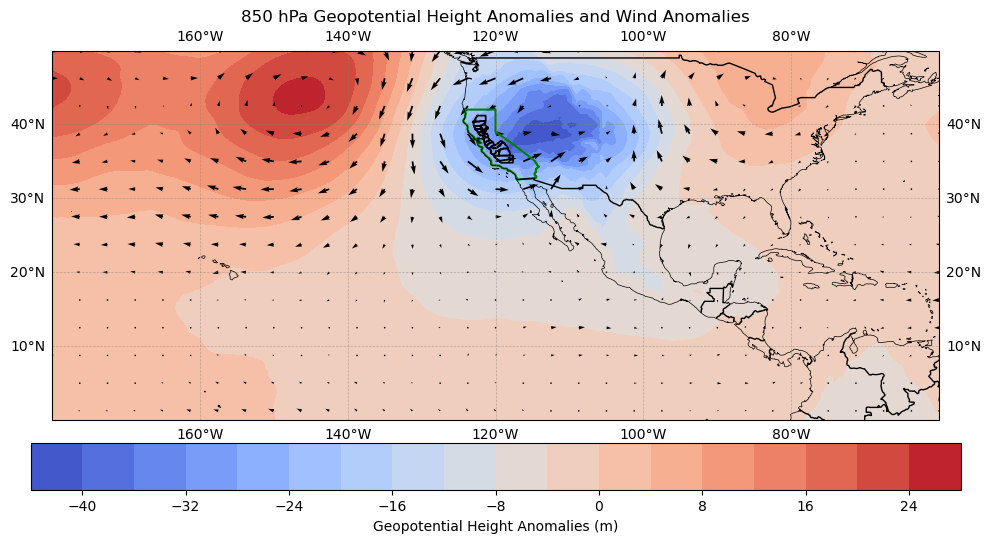

In [61]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u_dust = xr.open_dataset("u850_dust.nc")
u_clim = xr.open_dataset("u_clim.nc")
v_dust = xr.open_dataset("v850_dust.nc")
v_clim = xr.open_dataset("v_clim.nc")

# Calculate geopotential height anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict data to specific latitude and longitude bounds
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)
lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]
mean_anomalies = anomalies.mean(dim="valid_time")
mean_anomalies_restricted = mean_anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Reduce the 3D anomalies to 2D by selecting or averaging over the pressure_level
if 'pressure_level' in mean_anomalies_restricted.dims:
    mean_anomalies_2d = mean_anomalies_restricted['z'].mean(dim='pressure_level')  # Average over pressure_level
else:
    mean_anomalies_2d = mean_anomalies_restricted['z']  # If no pressure_level, keep as is

# Calculate wind anomalies
u_anomalies = (u_dust['u'] - u_clim['u']).sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time').squeeze()
v_anomalies = (v_dust['v'] - v_clim['v']).sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time').squeeze()

# Sparsify data for quiver plot
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)
quiver_spacing = 15
lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]
u_quiver = u_anomalies.values[::quiver_spacing, ::quiver_spacing]
v_quiver = v_anomalies.values[::quiver_spacing, ::quiver_spacing]

# Ensure shapes match
print(f"lon_quiver shape: {lon_quiver.shape}")
print(f"lat_quiver shape: {lat_quiver.shape}")
print(f"u_quiver shape: {u_quiver.shape}")
print(f"v_quiver shape: {v_quiver.shape}")

assert lon_quiver.shape == u_quiver.shape, "Longitude grid and U data shape mismatch"
assert lat_quiver.shape == v_quiver.shape, "Latitude grid and V data shape mismatch"

# Define shapefiles
california_shapefile = "california_shapefile.shp"
central_valley_shapefile = "central_valley_counties.shp"

# Plot composite anomalies and wind vectors
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, -60, 0, 50], crs=ccrs.PlateCarree())

# Plot anomalies (2D array)
anomaly_plot = ax.contourf(
    lon2d,
    lat2d,
    mean_anomalies_2d,
    levels=20,
    cmap='coolwarm',
    transform=ccrs.PlateCarree(),
)

# Add wind vectors
ax.quiver(
    lon_quiver, lat_quiver, u_quiver, v_quiver,
    scale=200, width=0.002, color='black', transform=ccrs.PlateCarree()
)

# Add California and Central Valley shapefiles
ax.add_feature(
    ShapelyFeature(
        Reader(california_shapefile).geometries(),
        ccrs.PlateCarree(),
        edgecolor='green',
        facecolor='none',
        linewidth=1.5
    )
)
ax.add_feature(
    ShapelyFeature(
        Reader(central_valley_shapefile).geometries(),
        ccrs.PlateCarree(),
        edgecolor='black',
        facecolor='none',
        linewidth=1.2
    )
)

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add gridlines and title
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax.set_title("850 hPa Geopotential Height Anomalies and Wind Anomalies")
cbar = fig.colorbar(anomaly_plot, ax=ax, orientation='horizontal', pad=0.05, label="Geopotential Height Anomalies (m)")
plt.savefig("850hpa_geopotential_height_with_wind_anomalies.png", dpi=300, bbox_inches='tight')
plt.show()


/home/precious/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Shape of anomalies_np: (1567, 201, 481)


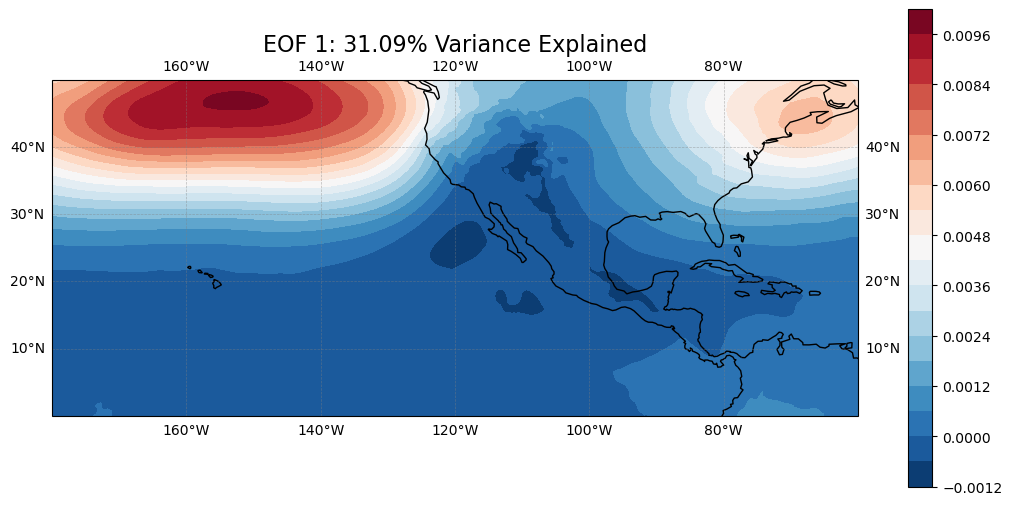

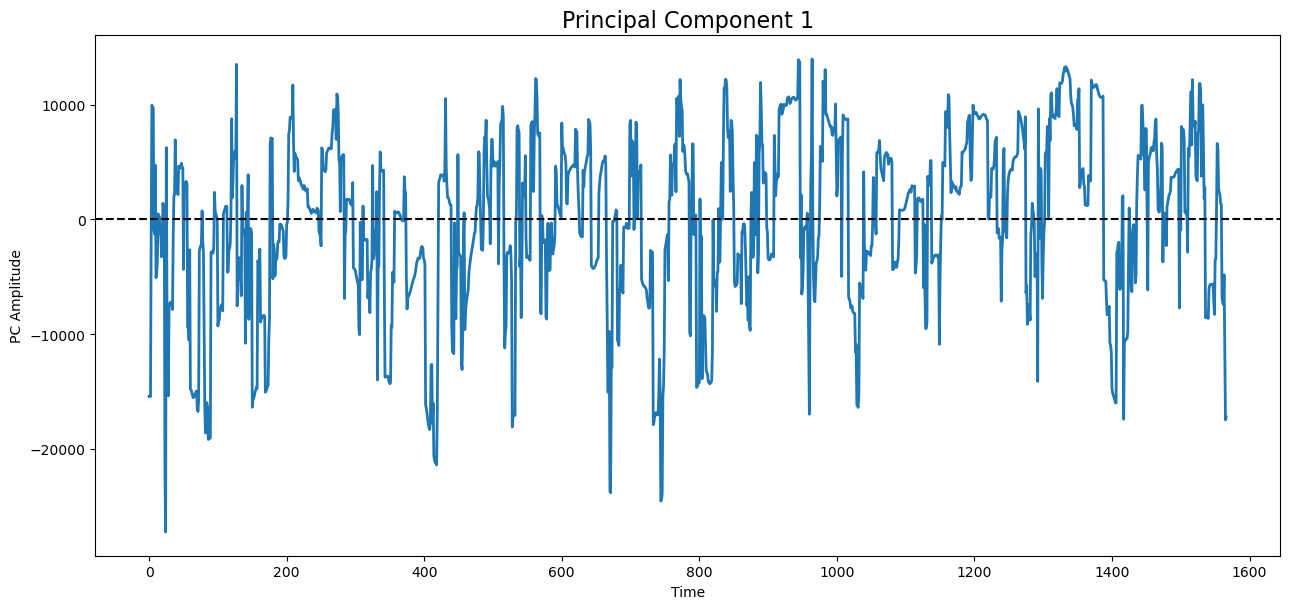

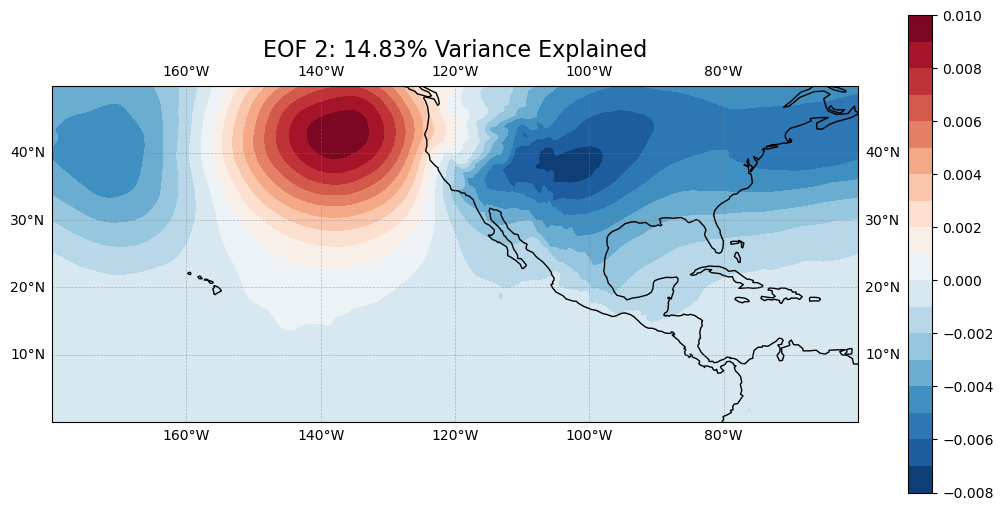

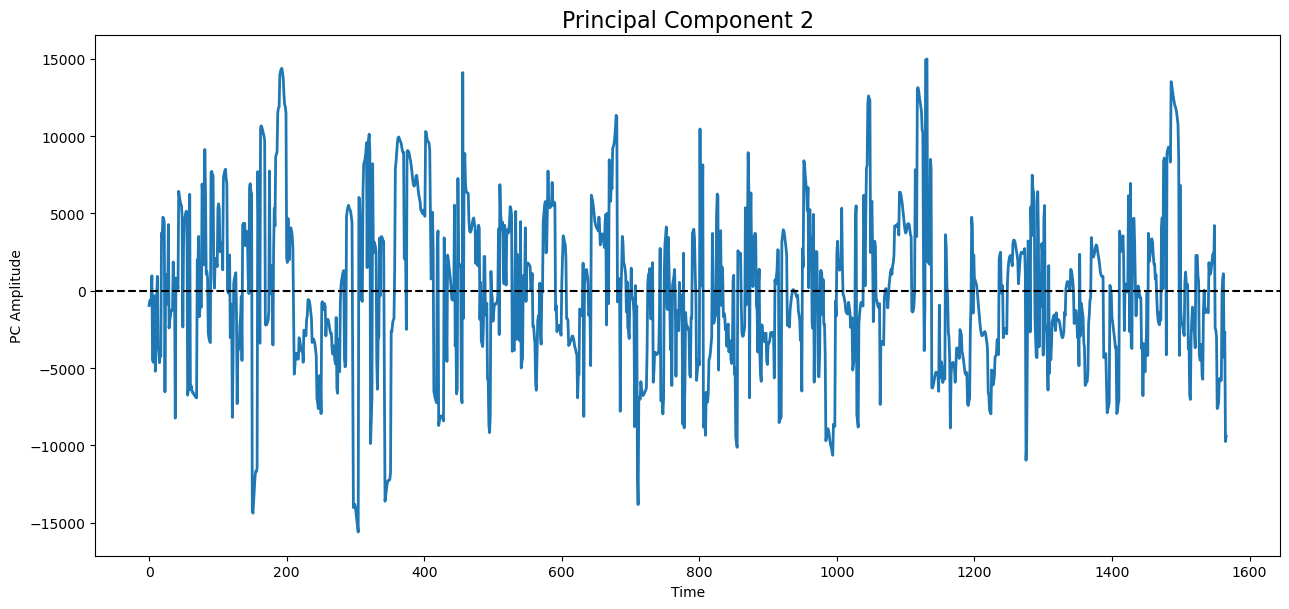

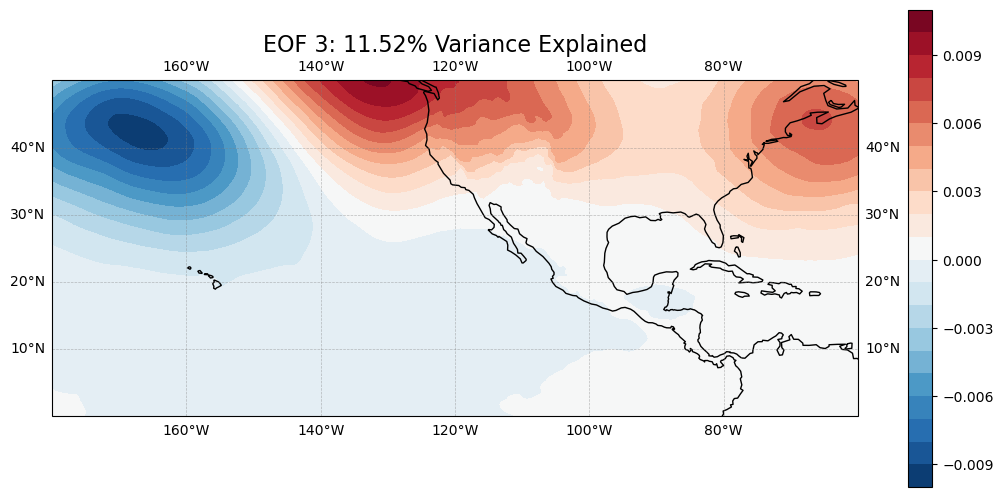

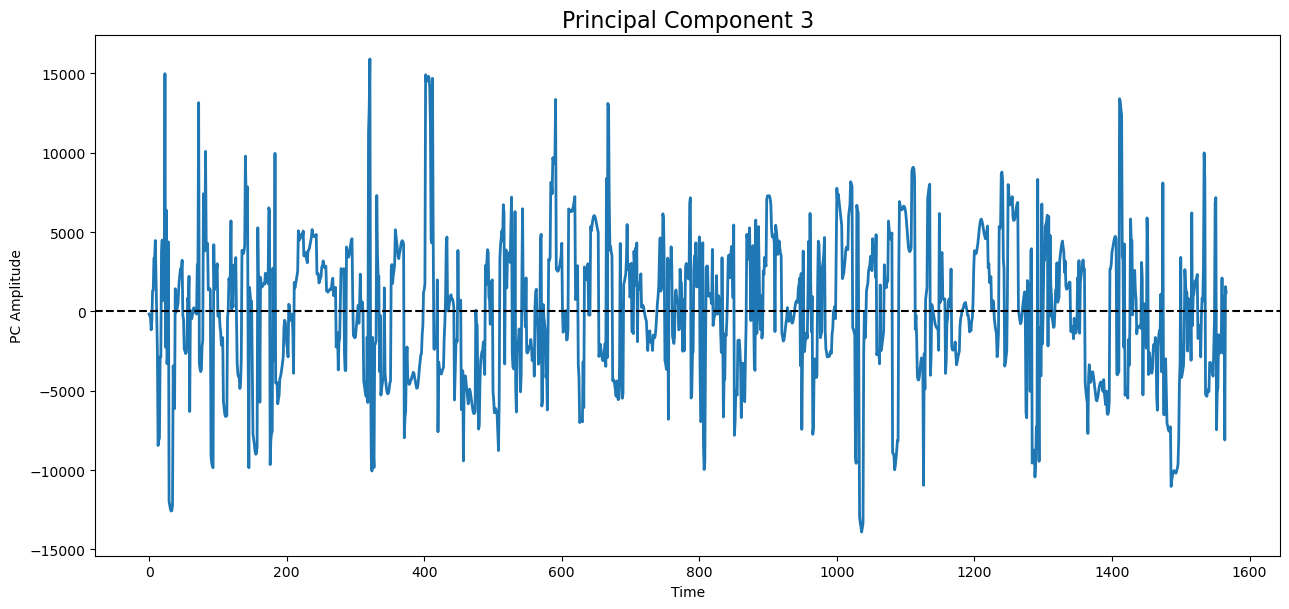

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")

# Calculate anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
# Assume 'z' is the variable for geopotential height
data = anomalies_restricted['z']

# Reduce data to 3D (time, lat, lon) by removing extra dimensions
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

# Compute time-mean anomalies and remove the mean
time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean

# Convert anomalies to a NumPy array for EOF analysis
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

# Check the shape of the data
print("Shape of anomalies_np:", anomalies_np.shape)

# Handle extra dimensions if needed
if anomalies_np.ndim == 3:
    n_times, n_lat, n_lon = anomalies_np.shape
elif anomalies_np.ndim == 4:  # Extra dimension (e.g., pressure_level)
    _, n_times, n_lat, n_lon = anomalies_np.shape
else:
    raise ValueError("Unexpected number of dimensions in anomalies_np.")

# Flatten spatial dimensions for EOF calculation
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

# Apply square-root cosine latitude weights
coslat = np.cos(np.deg2rad(lat_restricted))  # Shape: (lat,)
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)  # Expand to (lat, lon)
wgts = np.sqrt(coslat_2d).flatten()  # Flatten to match spatial dimensions of data_flat

# Initialize EOF solver with weights
solver = Eof(data_flat, weights=wgts)

# Retrieve the leading EOFs, PCs, and explained variance
eof_modes_flat = solver.eofs(neofs=3)  # Flattened EOFs
pcs = solver.pcs(npcs=3, pcscaling=0)  # Principal components
variance_fraction = solver.varianceFraction()

# Reshape EOFs back to spatial dimensions
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)  # (modes, lat, lon)

# Plot the leading EOFs
for i in range(3):  # Plot EOFs 1-3
    plt.figure(figsize=(13, 6.2))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],  # First EOF mode reshaped to 2D
        levels=20,
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    cb = plt.colorbar(fill, orientation='vertical')
    plt.title(f'EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance Explained', fontsize=16)
    plt.savefig(f"eof_{i + 1}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot the Principal Component for the corresponding EOF
    plt.figure(figsize=(13, 6.2))
    time_steps = np.arange(pcs.shape[0])
    plt.plot(time_steps, pcs[:, i], linewidth=2)
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('PC Amplitude')
    plt.title(f'Principal Component {i + 1}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"pc_{i + 1}.png", dpi=300, bbox_inches='tight')
    plt.show()


Shape of anomalies_np: (1567, 201, 481)


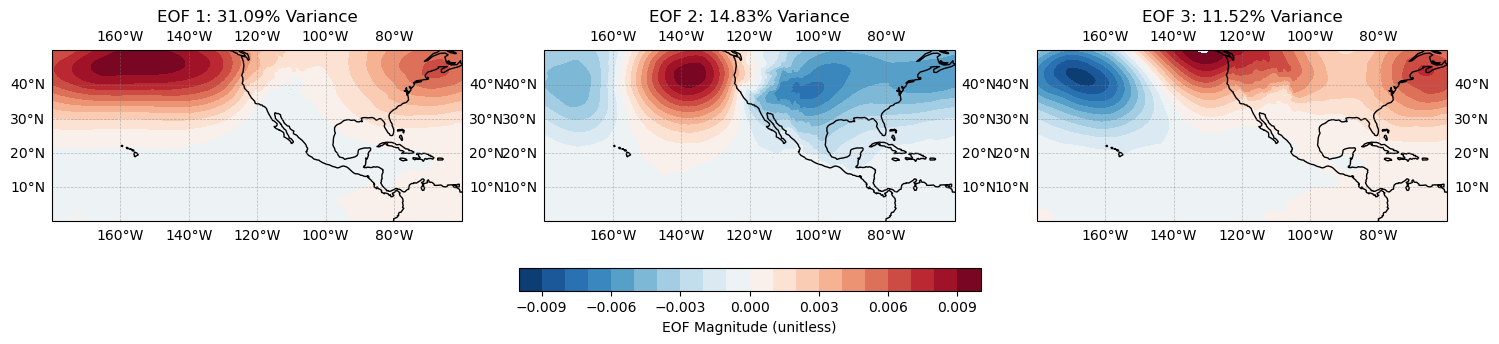

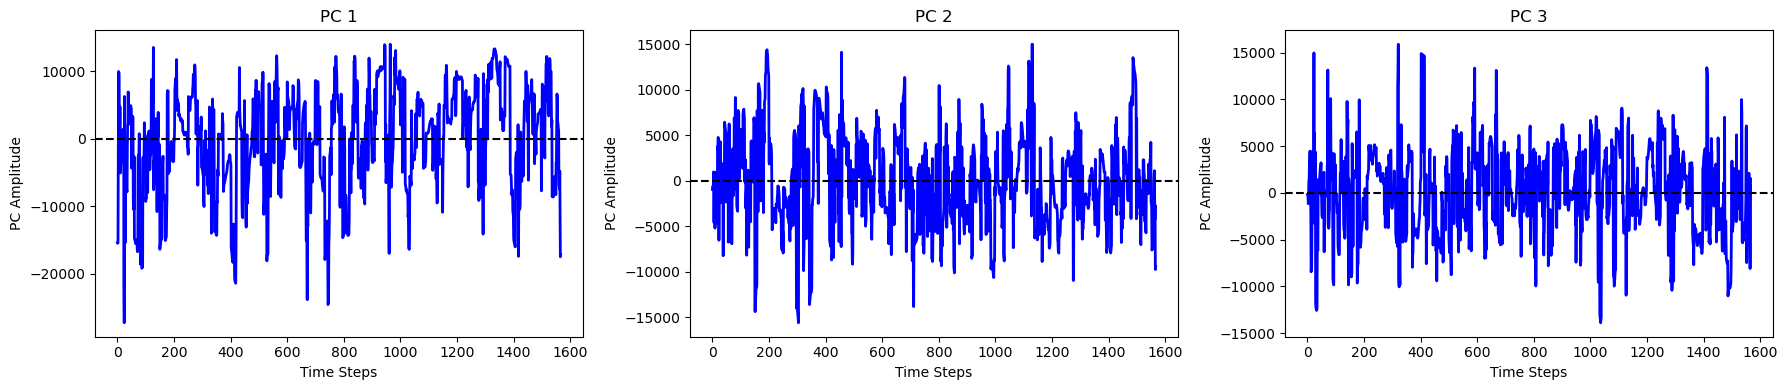

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")

# Calculate anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
# Assume 'z' is the variable for geopotential height
data = anomalies_restricted['z']

# Reduce data to 3D (time, lat, lon) by removing extra dimensions
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

# Compute time-mean anomalies and remove the mean
time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean

# Convert anomalies to a NumPy array for EOF analysis
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

# Check the shape of the data
print("Shape of anomalies_np:", anomalies_np.shape)

# Flatten spatial dimensions for EOF calculation
n_times, n_lat, n_lon = anomalies_np.shape
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

# Apply square-root cosine latitude weights
coslat = np.cos(np.deg2rad(lat_restricted))  # Shape: (lat,)
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)  # Expand to (lat, lon)
wgts = np.sqrt(coslat_2d).flatten()  # Flatten to match spatial dimensions of data_flat

# Initialize EOF solver with weights
solver = Eof(data_flat, weights=wgts)

# Retrieve the leading EOFs, PCs, and explained variance
eof_modes_flat = solver.eofs(neofs=3)  # Flattened EOFs
pcs = solver.pcs(npcs=3, pcscaling=0)  # Principal components
variance_fraction = solver.varianceFraction()

# Reshape EOFs back to spatial dimensions
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)  # (modes, lat, lon)

# Create a 1x3 grid for EOF maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],  # Reshape to 2D
        levels=np.linspace(-0.01, 0.01, 21),  # Adjust levels for better contrast
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)
cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_spatial_grid.png", dpi=300, bbox_inches='tight')
plt.show()

# Create a 1x3 grid for Principal Components
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axs):
    time_steps = np.arange(pcs.shape[0])
    ax.plot(time_steps, pcs[:, i], linewidth=2, color='blue')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f"PC {i + 1}", fontsize=12)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("PC Amplitude")
plt.tight_layout()
plt.savefig("pc_time_series_grid.png", dpi=300, bbox_inches='tight')
plt.show()


Shape of anomalies_np: (1567, 201, 481)


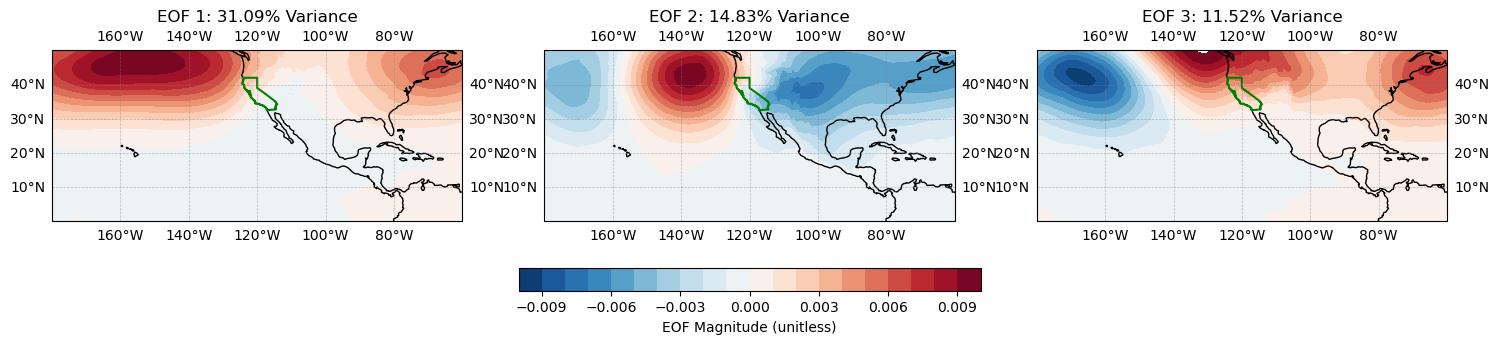

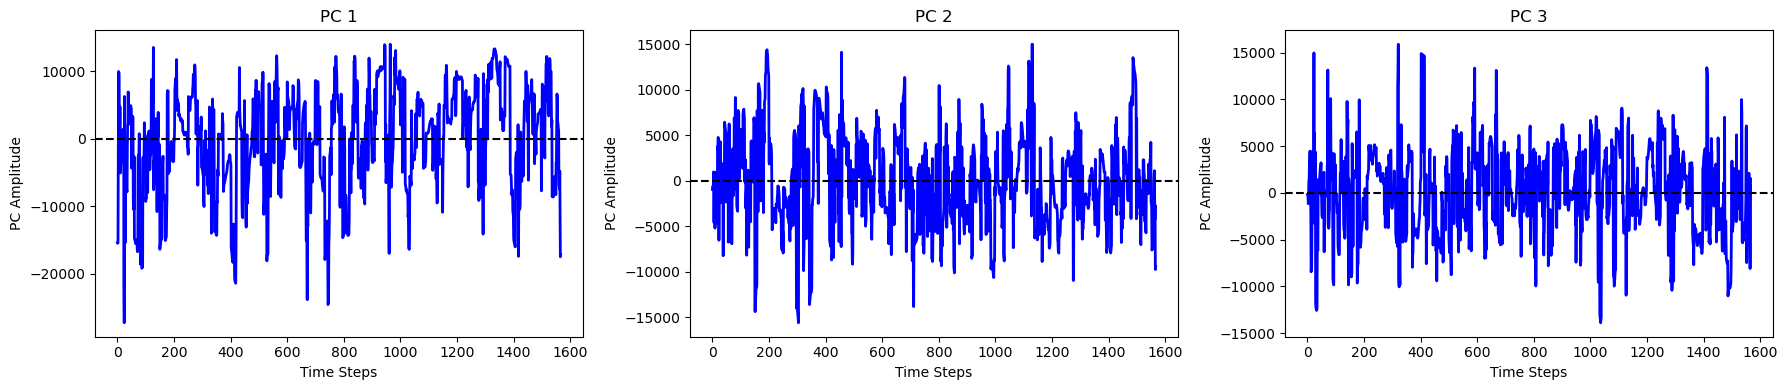

In [9]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")

# Calculate anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
# Assume 'z' is the variable for geopotential height
data = anomalies_restricted['z']

# Reduce data to 3D (time, lat, lon) by removing extra dimensions
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

# Compute time-mean anomalies and remove the mean
time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean

# Convert anomalies to a NumPy array for EOF analysis
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

# Check the shape of the data
print("Shape of anomalies_np:", anomalies_np.shape)

# Flatten spatial dimensions for EOF calculation
n_times, n_lat, n_lon = anomalies_np.shape
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

# Apply square-root cosine latitude weights
coslat = np.cos(np.deg2rad(lat_restricted))  # Shape: (lat,)
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)  # Expand to (lat, lon)
wgts = np.sqrt(coslat_2d).flatten()  # Flatten to match spatial dimensions of data_flat

# Initialize EOF solver with weights
solver = Eof(data_flat, weights=wgts)

# Retrieve the leading EOFs, PCs, and explained variance
eof_modes_flat = solver.eofs(neofs=3)  # Flattened EOFs
pcs = solver.pcs(npcs=3, pcscaling=0)  # Principal components
variance_fraction = solver.varianceFraction()

# Reshape EOFs back to spatial dimensions
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)  # (modes, lat, lon)

# Define the California and Central Valley shapefiles
california_shapefile = "california_shapefile.shp"  # Replace with the path to your California shapefile
central_valley_shapefile = "central_valley_counties.shp"  # Replace with the path to your Central Valley shapefile

# Create a 1x3 grid for EOF maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    
    # Add California boundaries
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green',
            facecolor='none',
            linewidth=1.5,
        )
    )
    
    # Add Central Valley outline
    ax.add_feature(
        ShapelyFeature(
            Reader(central_valley_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='black',
            facecolor='none',
            linewidth=0.01,
        )
    )
    
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],  # Reshape to 2D
        levels=np.linspace(-0.01, 0.01, 21),  # Adjust levels for better contrast
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)
cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_spatial_grid_with_central_valley.png", dpi=300, bbox_inches='tight')
plt.show()

# Create a 1x3 grid for Principal Components
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axs):
    time_steps = np.arange(pcs.shape[0])
    ax.plot(time_steps, pcs[:, i], linewidth=2, color='blue')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f"PC {i + 1}", fontsize=12)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("PC Amplitude")
plt.tight_layout()
plt.savefig("pc_time_series_grid.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_700203/3017027799.py:83: RuntimeWarning: overflow encountered in square
  wind_magnitude = np.sqrt(u_quiver**2 + v_quiver**2)  # Wind speed magnitude


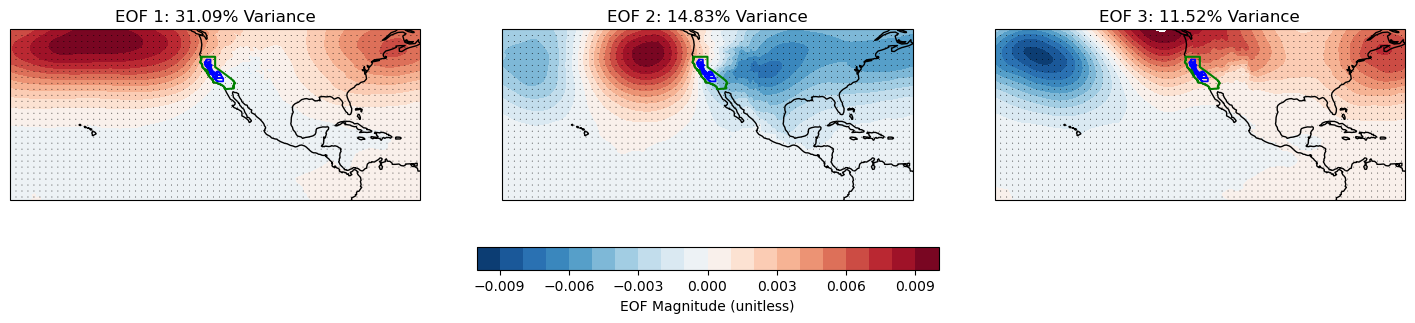

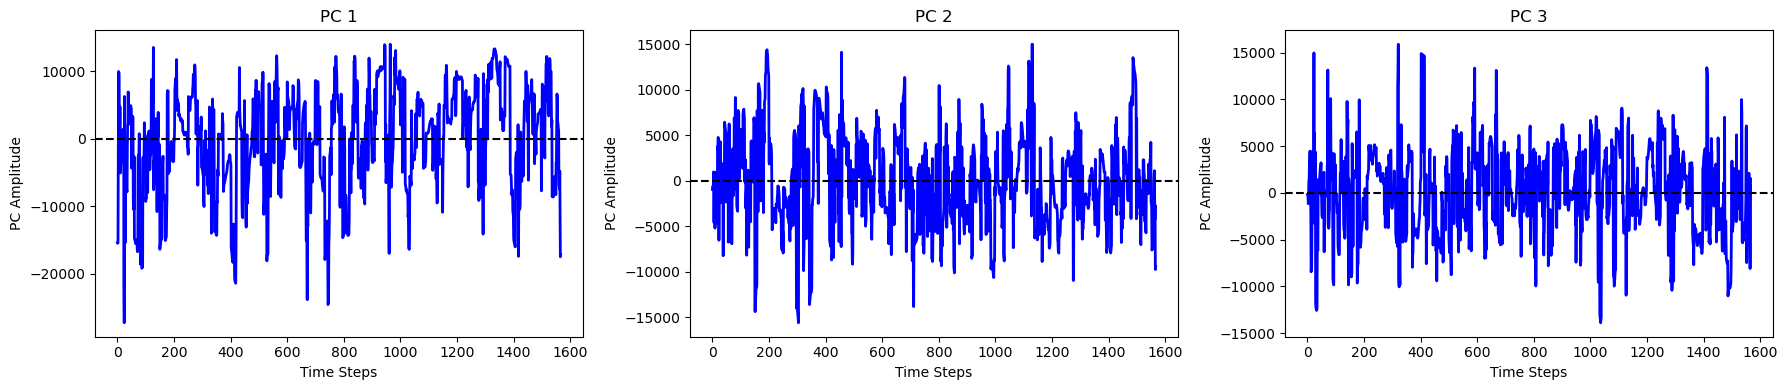

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u_wind = xr.open_dataset("u850_dust.nc")  # u-component of wind
v_wind = xr.open_dataset("v850_dust.nc")  # v-component of wind

# Calculate anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
# Assume 'z' is the variable for geopotential height
data = anomalies_restricted['z']

# Reduce data to 3D (time, lat, lon) by removing extra dimensions
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

# Compute time-mean anomalies and remove the mean
time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean

# Convert anomalies to a NumPy array for EOF analysis
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

# Flatten spatial dimensions for EOF calculation
n_times, n_lat, n_lon = anomalies_np.shape
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

# Apply square-root cosine latitude weights
coslat = np.cos(np.deg2rad(lat_restricted))  # Shape: (lat,)
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)  # Expand to (lat, lon)
wgts = np.sqrt(coslat_2d).flatten()  # Flatten to match spatial dimensions of data_flat

# Initialize EOF solver with weights
solver = Eof(data_flat, weights=wgts)

# Retrieve the leading EOFs, PCs, and explained variance
eof_modes_flat = solver.eofs(neofs=3)  # Flattened EOFs
pcs = solver.pcs(npcs=3, pcscaling=0)  # Principal components
variance_fraction = solver.varianceFraction()

# Reshape EOFs back to spatial dimensions
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)  # (modes, lat, lon)

# Process u and v wind data
# Restrict data to lat and lon bounds
u_restricted = u_wind['u'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')
v_restricted = v_wind['v'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')

# Ensure u and v are 2D arrays (lat, lon)
if 'pressure_level' in u_restricted.dims:
    u_restricted = u_restricted.mean(dim='pressure_level')
if 'pressure_level' in v_restricted.dims:
    v_restricted = v_restricted.mean(dim='pressure_level')

# Sparsify data for quiver plot
quiver_spacing = 7  # Adjust for clarity
lon_quiver = lon_restricted[::quiver_spacing]
lat_quiver = lat_restricted[::quiver_spacing]
u_quiver = u_restricted.values[::quiver_spacing, ::quiver_spacing]
v_quiver = v_restricted.values[::quiver_spacing, ::quiver_spacing]

# Normalize wind vectors
wind_magnitude = np.sqrt(u_quiver**2 + v_quiver**2)  # Wind speed magnitude
u_quiver_normalized = u_quiver / wind_magnitude.max()  # Normalize u
v_quiver_normalized = v_quiver / wind_magnitude.max()  # Normalize v

# Define the California and Central Valley shapefiles
california_shapefile = "california_shapefile.shp"  # Replace with the path to your California shapefile
central_valley_shapefile = "central_valley_counties.shp"  # Replace with the path to your Central Valley shapefile

# Create a 1x3 grid for EOF maps with wind vectors
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    
    # Add California and Central Valley boundaries
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green',
            facecolor='none',
            linewidth=1.5,
        )
    )
    ax.add_feature(
        ShapelyFeature(
            Reader(central_valley_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
        )
    )
    
    # Plot EOF anomalies
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],
        levels=np.linspace(-0.01, 0.01, 21),
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    
    # Overlay wind vectors
    ax.quiver(
        lon_quiver,
        lat_quiver,
        u_quiver_normalized,
        v_quiver_normalized,
        scale=20,  # Adjust scale for visual clarity
        color='black',
        transform=ccrs.PlateCarree(),
    )
    
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)

cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_spatial_with_winds_improved.png", dpi=300, bbox_inches='tight')
plt.show()

# Create a 1x3 grid for Principal Components
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axs):
    time_steps = np.arange(pcs.shape[0])
    ax.plot(time_steps, pcs[:, i], linewidth=2, color='blue')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f"PC {i + 1}", fontsize=12)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("PC Amplitude")
plt.tight_layout()
plt.savefig("pc_time_series_grid.png", dpi=300, bbox_inches='tight')
plt.show()


ValueError: too many values to unpack (expected 2)

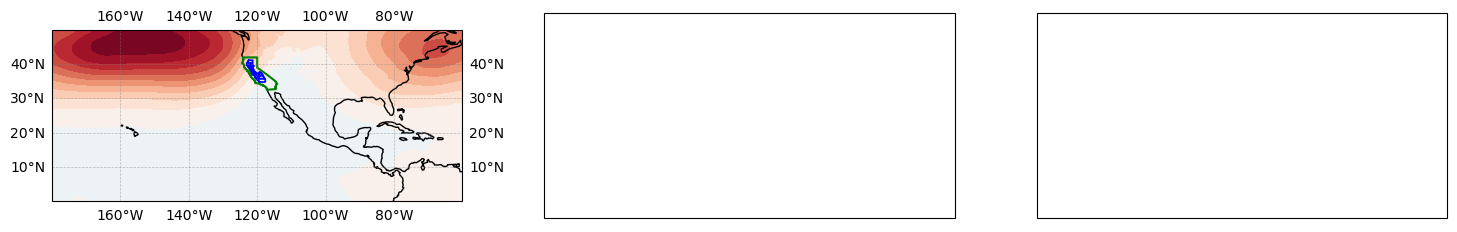

In [30]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u_dust = xr.open_dataset("u850_dust.nc")  # Dust event u-component
u_clim = xr.open_dataset("u_clim.nc")  # Climatology u-component
v_dust = xr.open_dataset("v850_dust.nc")  # Dust event v-component
v_clim = xr.open_dataset("v_clim.nc")  # Climatology v-component

# Calculate anomalies for geopotential height
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
data = anomalies_restricted['z']
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

n_times, n_lat, n_lon = anomalies_np.shape
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

coslat = np.cos(np.deg2rad(lat_restricted))
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)
wgts = np.sqrt(coslat_2d).flatten()

solver = Eof(data_flat, weights=wgts)
eof_modes_flat = solver.eofs(neofs=3)
pcs = solver.pcs(npcs=3, pcscaling=0)
variance_fraction = solver.varianceFraction()
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)

# Calculate wind anomalies
u_anomalies = (u_dust['u'] - u_clim['u']).sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')
v_anomalies = (v_dust['v'] - v_clim['v']).sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')

# Sparsify data for quiver plot
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)
quiver_spacing = 15
lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]
u_quiver = u_anomalies.values[::quiver_spacing, ::quiver_spacing]
v_quiver = v_anomalies.values[::quiver_spacing, ::quiver_spacing]

# Define shapefiles
california_shapefile = "california_shapefile.shp"
central_valley_shapefile = "central_valley_counties.shp"

# Plot EOFs with wind anomalies
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green',
            facecolor='none',
            linewidth=1.5,
        )
    )
    ax.add_feature(
        ShapelyFeature(
            Reader(central_valley_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
        )
    )
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],
        levels=np.linspace(-0.01, 0.01, 21),
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    # Overlay wind anomaly vectors
    ax.quiver(
        lon_quiver,
        lat_quiver,
        u_quiver,
        v_quiver,
        scale=200, width=0.002, color='black', transform=ccrs.PlateCarree()
    )
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)

cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_with_wind_anomalies.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Principal Components
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axs):
    time_steps = np.arange(pcs.shape[0])
    ax.plot(time_steps, pcs[:, i], linewidth=2, color='blue')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f"PC {i + 1}", fontsize=12)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("PC Amplitude")
plt.tight_layout()
plt.savefig("pc_with_wind_anomalies.png", dpi=300, bbox_inches='tight')
plt.show()


lon_quiver shape: (14, 33)
lat_quiver shape: (14, 33)
u_quiver shape: (14, 33)
v_quiver shape: (14, 33)


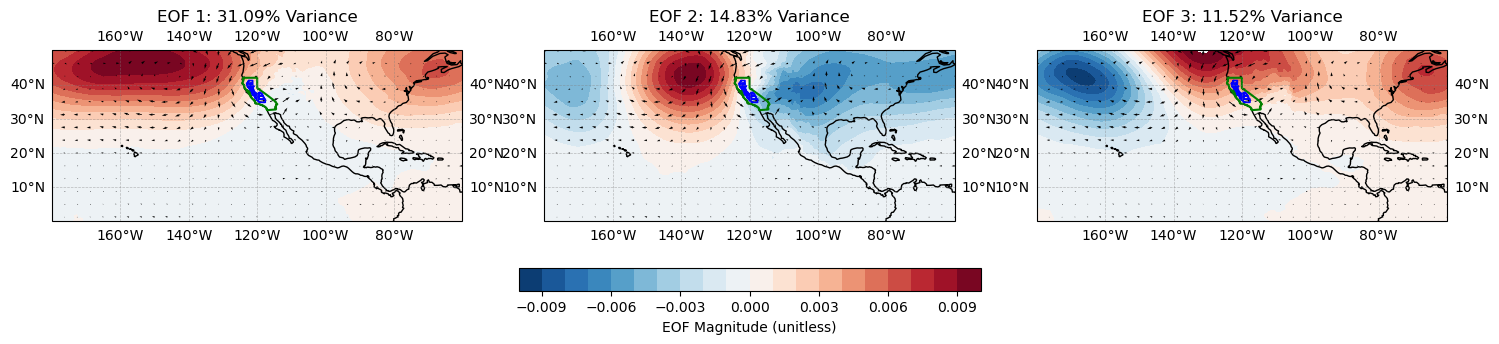

In [32]:
# Sparsify data for quiver plot
quiver_spacing = 15  # Adjust spacing for clarity
lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]

# Squeeze the wind anomalies to remove the singleton dimension
u_quiver = u_anomalies.values.squeeze()[::quiver_spacing, ::quiver_spacing]
v_quiver = v_anomalies.values.squeeze()[::quiver_spacing, ::quiver_spacing]

# Ensure shapes match
print(f"lon_quiver shape: {lon_quiver.shape}")
print(f"lat_quiver shape: {lat_quiver.shape}")
print(f"u_quiver shape: {u_quiver.shape}")
print(f"v_quiver shape: {v_quiver.shape}")

assert lon_quiver.shape == u_quiver.shape, "Longitude grid and U data shape mismatch"
assert lat_quiver.shape == v_quiver.shape, "Latitude grid and V data shape mismatch"

# Plot EOFs with wind anomalies
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green',
            facecolor='none',
            linewidth=1.5,
        )
    )
    ax.add_feature(
        ShapelyFeature(
            Reader(central_valley_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
        )
    )
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],
        levels=np.linspace(-0.01, 0.01, 21),
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    # Overlay wind anomaly vectors
    ax.quiver(
        lon_quiver,
        lat_quiver,
        u_quiver,
        v_quiver,
        scale=200, width=0.002, color='black', transform=ccrs.PlateCarree()
    )
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)

cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_with_wind_anomalies_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


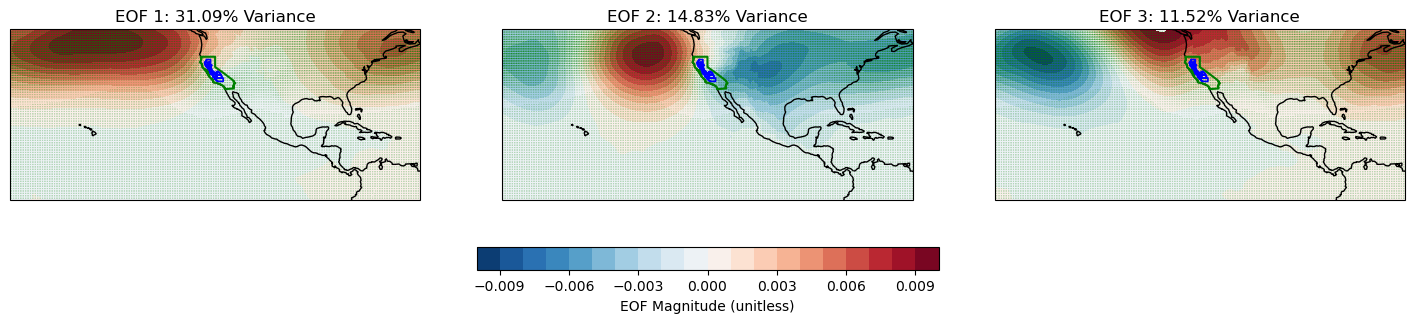

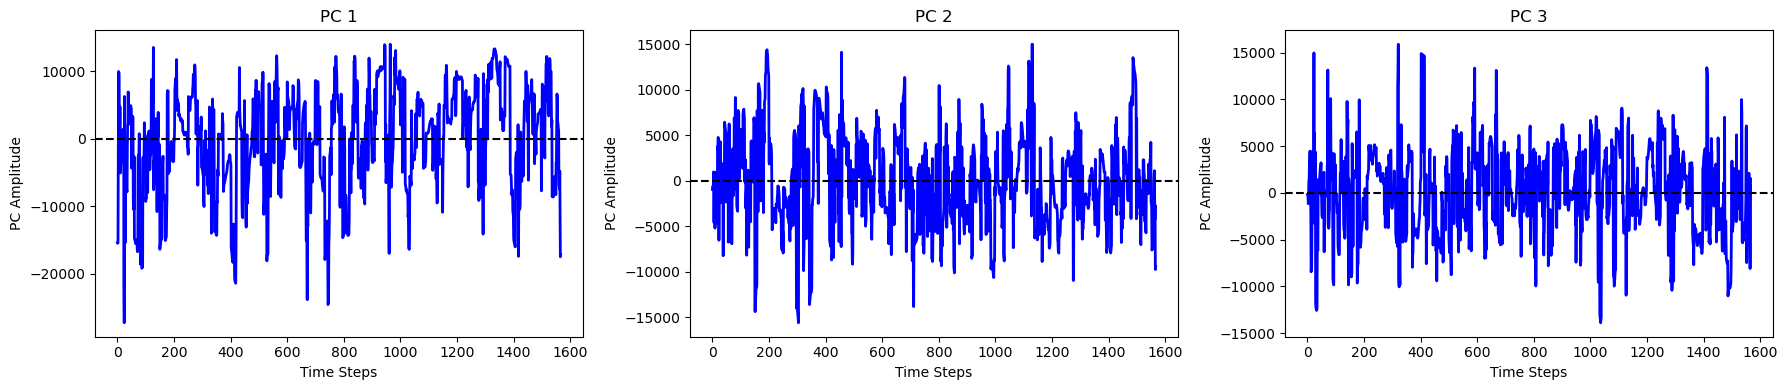

In [26]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u_wind = xr.open_dataset("u850_dust.nc")  # u-component of wind
v_wind = xr.open_dataset("v850_dust.nc")  # v-component of wind

# Calculate anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
# Assume 'z' is the variable for geopotential height
data = anomalies_restricted['z']

# Reduce data to 3D (time, lat, lon) by removing extra dimensions
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

# Compute time-mean anomalies and remove the mean
time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean

# Convert anomalies to a NumPy array for EOF analysis
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

# Flatten spatial dimensions for EOF calculation
n_times, n_lat, n_lon = anomalies_np.shape
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

# Apply square-root cosine latitude weights
coslat = np.cos(np.deg2rad(lat_restricted))  # Shape: (lat,)
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)  # Expand to (lat, lon)
wgts = np.sqrt(coslat_2d).flatten()  # Flatten to match spatial dimensions of data_flat

# Initialize EOF solver with weights
solver = Eof(data_flat, weights=wgts)

# Retrieve the leading EOFs, PCs, and explained variance
eof_modes_flat = solver.eofs(neofs=3)  # Flattened EOFs
pcs = solver.pcs(npcs=3, pcscaling=0)  # Principal components
variance_fraction = solver.varianceFraction()

# Reshape EOFs back to spatial dimensions
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)  # (modes, lat, lon)

# Process u and v wind data
# Restrict data to lat and lon bounds
u_restricted = u_wind['u'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')
v_restricted = v_wind['v'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')

# Ensure u and v are 2D arrays (lat, lon)
if 'pressure_level' in u_restricted.dims:
    u_restricted = u_restricted.mean(dim='pressure_level')
if 'pressure_level' in v_restricted.dims:
    v_restricted = v_restricted.mean(dim='pressure_level')

# Create a meshgrid for sparse quiver plotting
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)

# Sparsify data for quiver plot
quiver_spacing = 2  # Adjust for clarity
u_quiver = u_restricted.values[::quiver_spacing, ::quiver_spacing]
v_quiver = v_restricted.values[::quiver_spacing, ::quiver_spacing]
lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]

# Normalize wind vectors
wind_magnitude = np.sqrt(u_quiver**2 + v_quiver**2)  # Wind speed magnitude
u_quiver_normalized = u_quiver / wind_magnitude.max()  # Normalize u
v_quiver_normalized = v_quiver / wind_magnitude.max()  # Normalize v

# Define the California and Central Valley shapefiles
california_shapefile = "california_shapefile.shp"  # Replace with the path to your California shapefile
central_valley_shapefile = "central_valley_counties.shp"  # Replace with the path to your Central Valley shapefile

# Create a 1x3 grid for EOF maps with wind vectors
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    
    # Add California and Central Valley boundaries
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green',
            facecolor='none',
            linewidth=1.5,
        )
    )
    ax.add_feature(
        ShapelyFeature(
            Reader(central_valley_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
        )
    )
    
    # Plot EOF anomalies
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],
        levels=np.linspace(-0.01, 0.01, 21),
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    
    # Overlay wind vectors as quivers with sparse spacing
    ax.quiver(
        lon_quiver,
        lat_quiver,
        u_quiver_normalized,
        v_quiver_normalized,
        scale=200,  # Adjust scale for visual clarity
        color='green',
        width=0.0015,
        transform=ccrs.PlateCarree(),
    )
    
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)

cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_spatial_with_winds_sparse.png", dpi=300, bbox_inches='tight')
plt.show()

# Create a 1x3 grid for Principal Components
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axs):
    time_steps = np.arange(pcs.shape[0])
    ax.plot(time_steps, pcs[:, i], linewidth=2, color='blue')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f"PC {i + 1}", fontsize=12)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("PC Amplitude")
plt.tight_layout()
plt.savefig("pc_time_series_grid_sparse.png", dpi=300, bbox_inches='tight')
plt.show()


lon_quiver shape: (14, 33)
lat_quiver shape: (14, 33)
u_quiver shape: (14, 33)
v_quiver shape: (14, 33)


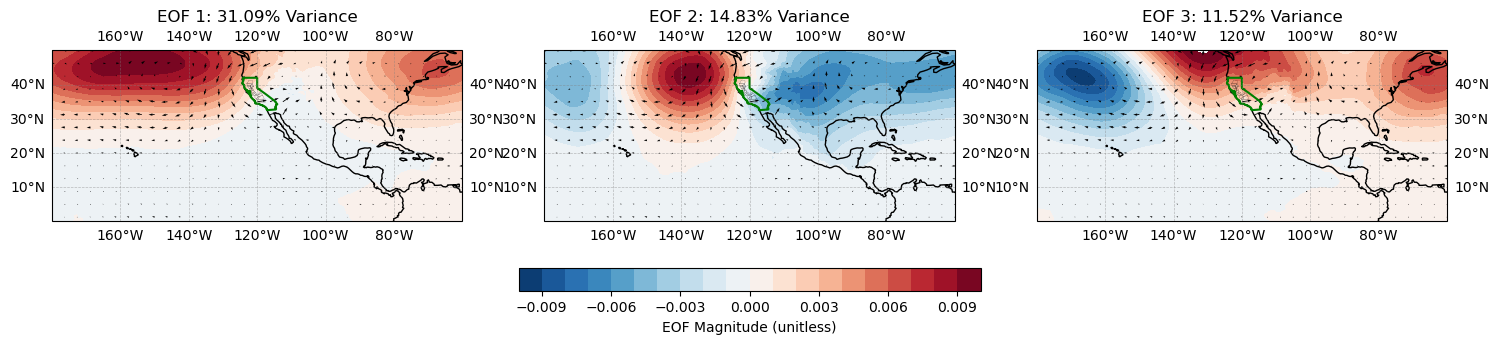

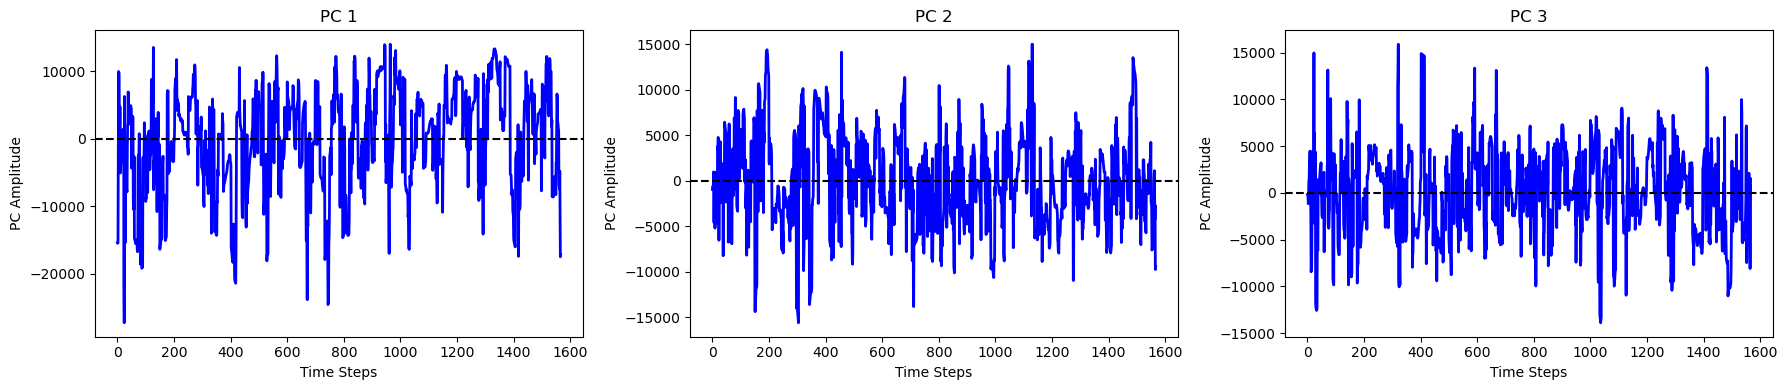

In [36]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u_dust = xr.open_dataset("u850_dust.nc")  # Dust event u-component
u_clim = xr.open_dataset("u_clim.nc")  # Climatology u-component
v_dust = xr.open_dataset("v850_dust.nc")  # Dust event v-component
v_clim = xr.open_dataset("v_clim.nc")  # Climatology v-component

# Calculate anomalies for geopotential height
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
data = anomalies_restricted['z']
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

n_times, n_lat, n_lon = anomalies_np.shape
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

coslat = np.cos(np.deg2rad(lat_restricted))
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)
wgts = np.sqrt(coslat_2d).flatten()

solver = Eof(data_flat, weights=wgts)
eof_modes_flat = solver.eofs(neofs=3)
pcs = solver.pcs(npcs=3, pcscaling=0)
variance_fraction = solver.varianceFraction()
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)

# Calculate wind anomalies
u_anomalies = (u_dust['u'] - u_clim['u']).sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')
v_anomalies = (v_dust['v'] - v_clim['v']).sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')

# Sparsify data for quiver plot
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)
quiver_spacing = 15
lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]
u_quiver = u_anomalies.values.squeeze()[::quiver_spacing, ::quiver_spacing]
v_quiver = v_anomalies.values.squeeze()[::quiver_spacing, ::quiver_spacing]

# Ensure shapes match
print(f"lon_quiver shape: {lon_quiver.shape}")
print(f"lat_quiver shape: {lat_quiver.shape}")
print(f"u_quiver shape: {u_quiver.shape}")
print(f"v_quiver shape: {v_quiver.shape}")

assert lon_quiver.shape == u_quiver.shape, "Longitude grid and U data shape mismatch"
assert lat_quiver.shape == v_quiver.shape, "Latitude grid and V data shape mismatch"

# Define shapefiles
california_shapefile = "california_shapefile.shp"
central_valley_shapefile = "central_valley_counties.shp"

# Plot EOFs with wind anomalies
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green',
            facecolor='none',
            linewidth=1.5,
        )
    )
    ax.add_feature(
        ShapelyFeature(
            Reader(central_valley_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='black',
            facecolor='none',
            linewidth=0.1,
        )
    )
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],
        levels=np.linspace(-0.01, 0.01, 21),
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    # Overlay wind anomaly vectors
    ax.quiver(
        lon_quiver,
        lat_quiver,
        u_quiver,
        v_quiver,
        scale=200, width=0.002, color='black', transform=ccrs.PlateCarree()
    )
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)

cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_with_wind_anomalies_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Principal Components
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axs):
    time_steps = np.arange(pcs.shape[0])
    ax.plot(time_steps, pcs[:, i], linewidth=2, color='blue')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f"PC {i + 1}", fontsize=12)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("PC Amplitude")
plt.tight_layout()
plt.savefig("pc_with_wind_anomalies.png", dpi=300, bbox_inches='tight')
plt.show()


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

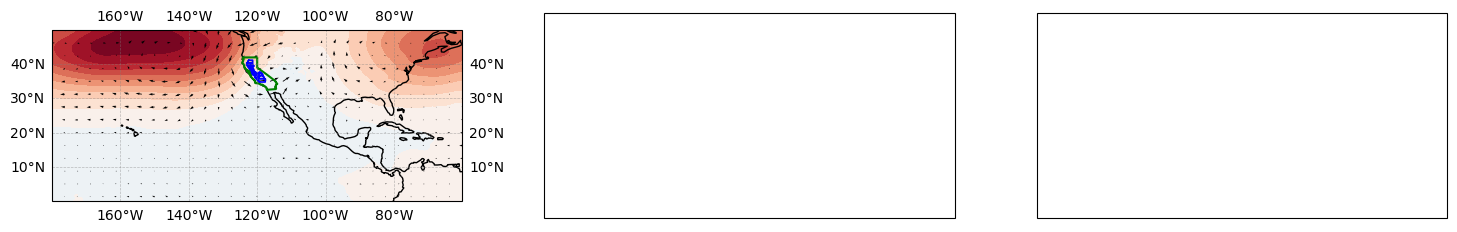

In [35]:
# Average wind anomalies and squeeze to remove extra dimensions
u_anomalies_mean = u_anomalies.mean(dim='valid_time').values.squeeze()
v_anomalies_mean = v_anomalies.mean(dim='valid_time').values.squeeze()

# Sparsify data for quiver plot
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)
quiver_spacing = 15  # Adjust spacing
lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]
u_quiver = u_anomalies_mean[::quiver_spacing, ::quiver_spacing]
v_quiver = v_anomalies_mean[::quiver_spacing, ::quiver_spacing]

# Ensure shapes match
assert lon_quiver.shape == u_quiver.shape, f"Mismatch: lon_quiver {lon_quiver.shape}, u_quiver {u_quiver.shape}"
assert lat_quiver.shape == v_quiver.shape, f"Mismatch: lat_quiver {lat_quiver.shape}, v_quiver {v_quiver.shape}"

# Perform t-tests for significance
t_stat_u, p_values_u = ttest_1samp(u_anomalies.values, 0, axis=0, nan_policy="omit")
t_stat_v, p_values_v = ttest_1samp(v_anomalies.values, 0, axis=0, nan_policy="omit")

# Apply significance mask
significance_mask_u = p_values_u < 0.05
significance_mask_v = p_values_v < 0.05

# Apply sparsity to the significance mask
significant_u = significance_mask_u[::quiver_spacing, ::quiver_spacing]
significant_v = significance_mask_v[::quiver_spacing, ::quiver_spacing]

# Overlay both significant and non-significant quivers in the plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green',
            facecolor='none',
            linewidth=1.5,
        )
    )
    ax.add_feature(
        ShapelyFeature(
            Reader(central_valley_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
        )
    )
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],
        levels=np.linspace(-0.01, 0.01, 21),
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    # Overlay non-significant wind vectors (black)
    ax.quiver(
        lon_quiver,
        lat_quiver,
        u_quiver,
        v_quiver,
        scale=200,
        width=0.002,
        color='black',
        transform=ccrs.PlateCarree()
    )
    # Overlay significant wind vectors (green)
    ax.quiver(
        lon_quiver[significant_u & significant_v],
        lat_quiver[significant_u & significant_v],
        u_quiver[significant_u & significant_v],
        v_quiver[significant_u & significant_v],
        scale=200,
        width=0.002,
        color='green',
        transform=ccrs.PlateCarree()
    )
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)

cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_with_significant_wind_anomalies_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


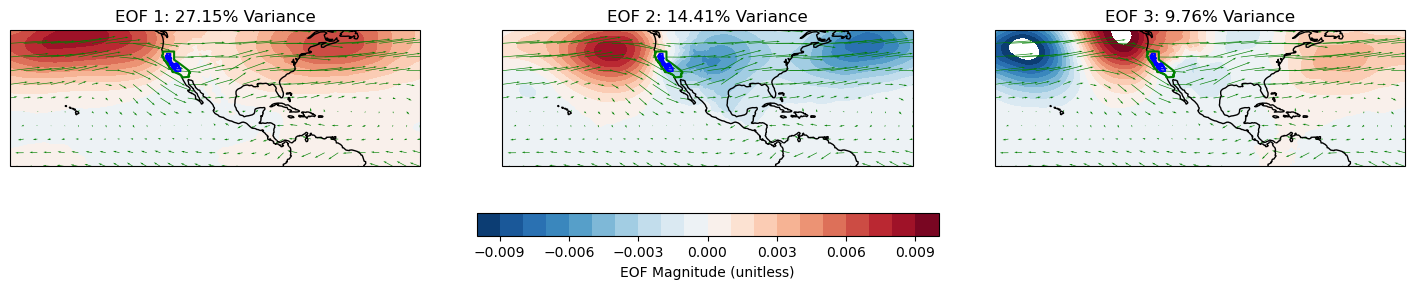

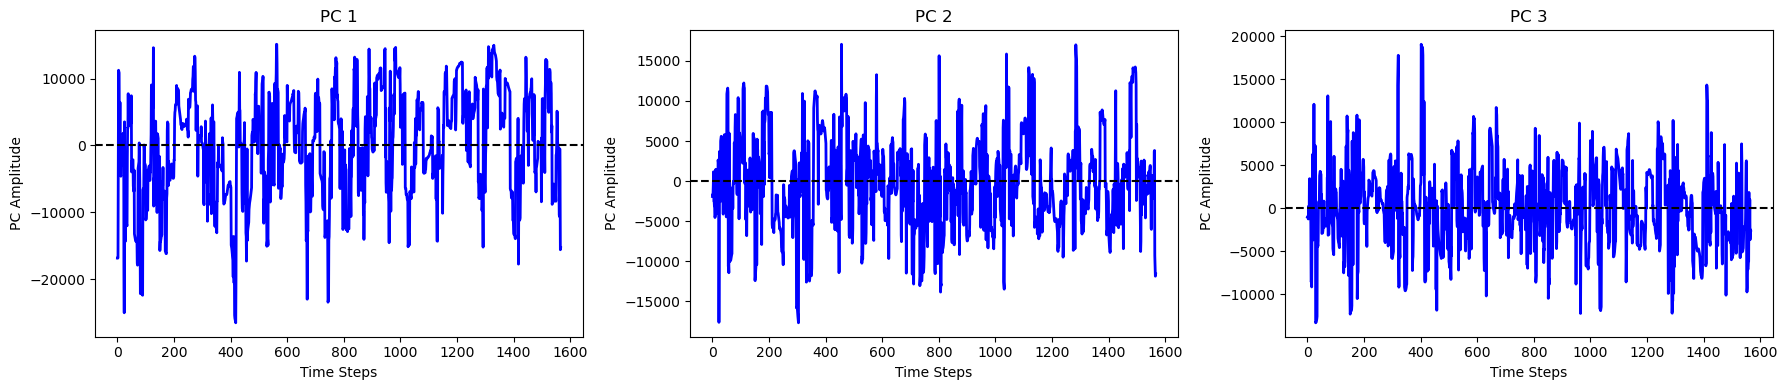

In [27]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u_wind = xr.open_dataset("u850_dust.nc")  # u-component of wind
v_wind = xr.open_dataset("v850_dust.nc")  # v-component of wind

# Calculate anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -30)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
# Assume 'z' is the variable for geopotential height
data = anomalies_restricted['z']

# Reduce data to 3D (time, lat, lon) by removing extra dimensions
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

# Compute time-mean anomalies and remove the mean
time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean

# Convert anomalies to a NumPy array for EOF analysis
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

# Flatten spatial dimensions for EOF calculation
n_times, n_lat, n_lon = anomalies_np.shape
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

# Apply square-root cosine latitude weights
coslat = np.cos(np.deg2rad(lat_restricted))  # Shape: (lat,)
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)  # Expand to (lat, lon)
wgts = np.sqrt(coslat_2d).flatten()  # Flatten to match spatial dimensions of data_flat

# Initialize EOF solver with weights
solver = Eof(data_flat, weights=wgts)

# Retrieve the leading EOFs, PCs, and explained variance
eof_modes_flat = solver.eofs(neofs=3)  # Flattened EOFs
pcs = solver.pcs(npcs=3, pcscaling=0)  # Principal components
variance_fraction = solver.varianceFraction()

# Reshape EOFs back to spatial dimensions
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)  # (modes, lat, lon)

# Process u and v wind data
# Restrict data to lat and lon bounds
u_restricted = u_wind['u'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')
v_restricted = v_wind['v'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='valid_time')

# Ensure u and v are 2D arrays (lat, lon)
if 'pressure_level' in u_restricted.dims:
    u_restricted = u_restricted.mean(dim='pressure_level')
if 'pressure_level' in v_restricted.dims:
    v_restricted = v_restricted.mean(dim='pressure_level')

# Create a meshgrid for sparse quiver plotting
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)

# Sparsify data for quiver plot
quiver_spacing = 20  # Increase spacing for clarity
u_quiver = u_restricted.values[::quiver_spacing, ::quiver_spacing]
v_quiver = v_restricted.values[::quiver_spacing, ::quiver_spacing]
lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]

# Define the California and Central Valley shapefiles
california_shapefile = "california_shapefile.shp"  # Replace with the path to your California shapefile
central_valley_shapefile = "central_valley_counties.shp"  # Replace with the path to your Central Valley shapefile

# Create a 1x3 grid for EOF maps with wind vectors
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs):
    ax.coastlines(resolution='110m')
    
    # Add California and Central Valley boundaries
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green',
            facecolor='none',
            linewidth=1.5,
        )
    )
    ax.add_feature(
        ShapelyFeature(
            Reader(central_valley_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
        )
    )
    
    # Plot EOF anomalies
    fill = ax.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],
        levels=np.linspace(-0.01, 0.01, 21),
        cmap=plt.cm.RdBu_r,
        transform=ccrs.PlateCarree(),
    )
    
    # Overlay wind vectors as quivers with sparse spacing
    ax.quiver(
        lon_quiver,
        lat_quiver,
        u_quiver,
        v_quiver,
        scale=200,  # Adjust scale for visual clarity
        color='green',
        width=0.0015,
        transform=ccrs.PlateCarree(),
    )
    
    ax.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance", fontsize=12)

cbar = fig.colorbar(fill, ax=axs, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_label("EOF Magnitude (unitless)")
plt.savefig("eof_spatial_with_winds_sparse_no_normalization.png", dpi=300, bbox_inches='tight')
plt.show()

# Create a 1x3 grid for Principal Components
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axs):
    time_steps = np.arange(pcs.shape[0])
    ax.plot(time_steps, pcs[:, i], linewidth=2, color='blue')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f"PC {i + 1}", fontsize=12)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("PC Amplitude")
plt.tight_layout()
plt.savefig("pc_time_series_grid_no_normalization.png", dpi=300, bbox_inches='tight')
plt.show()


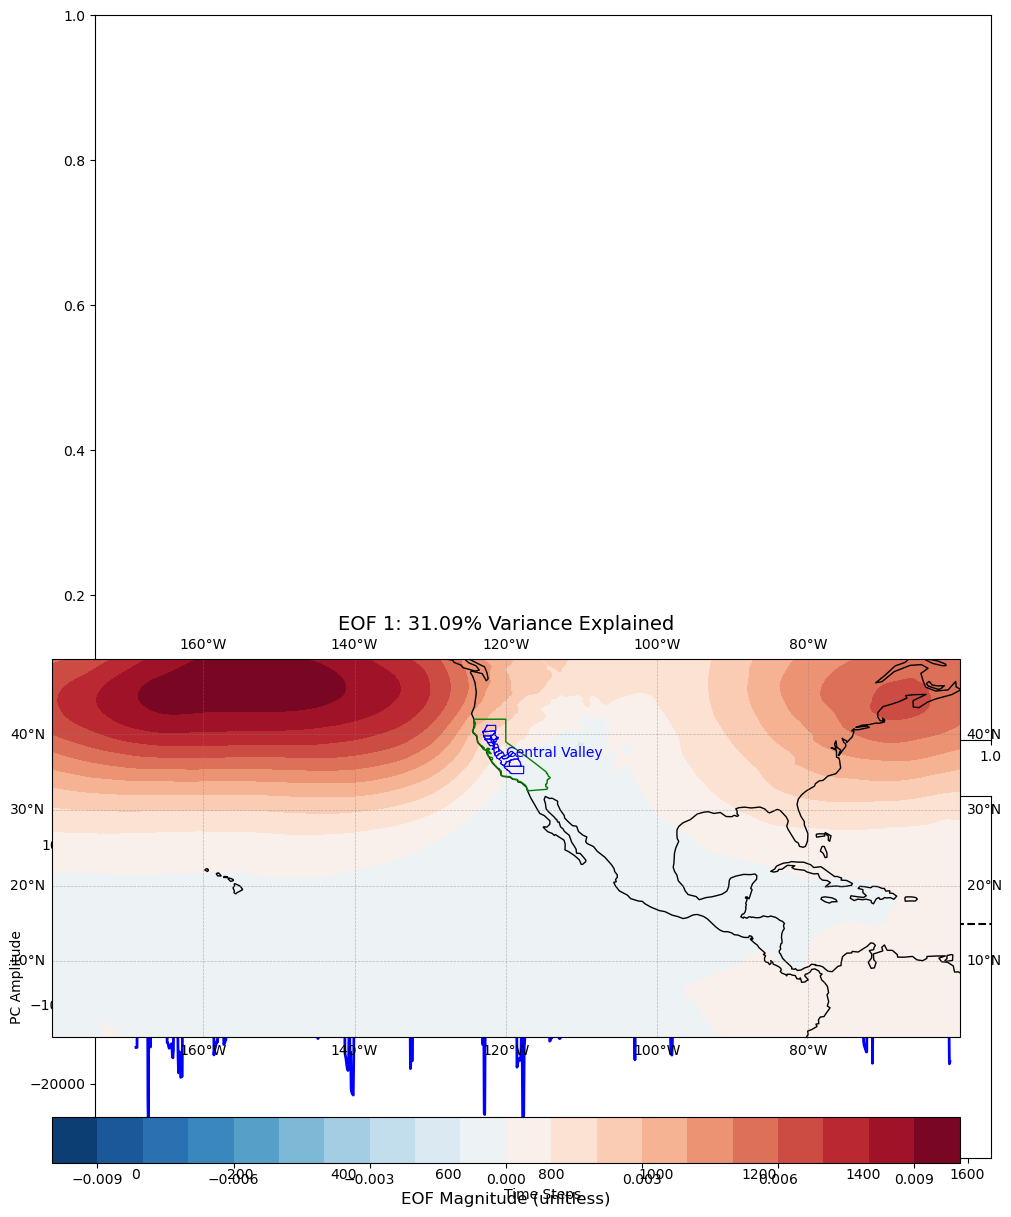

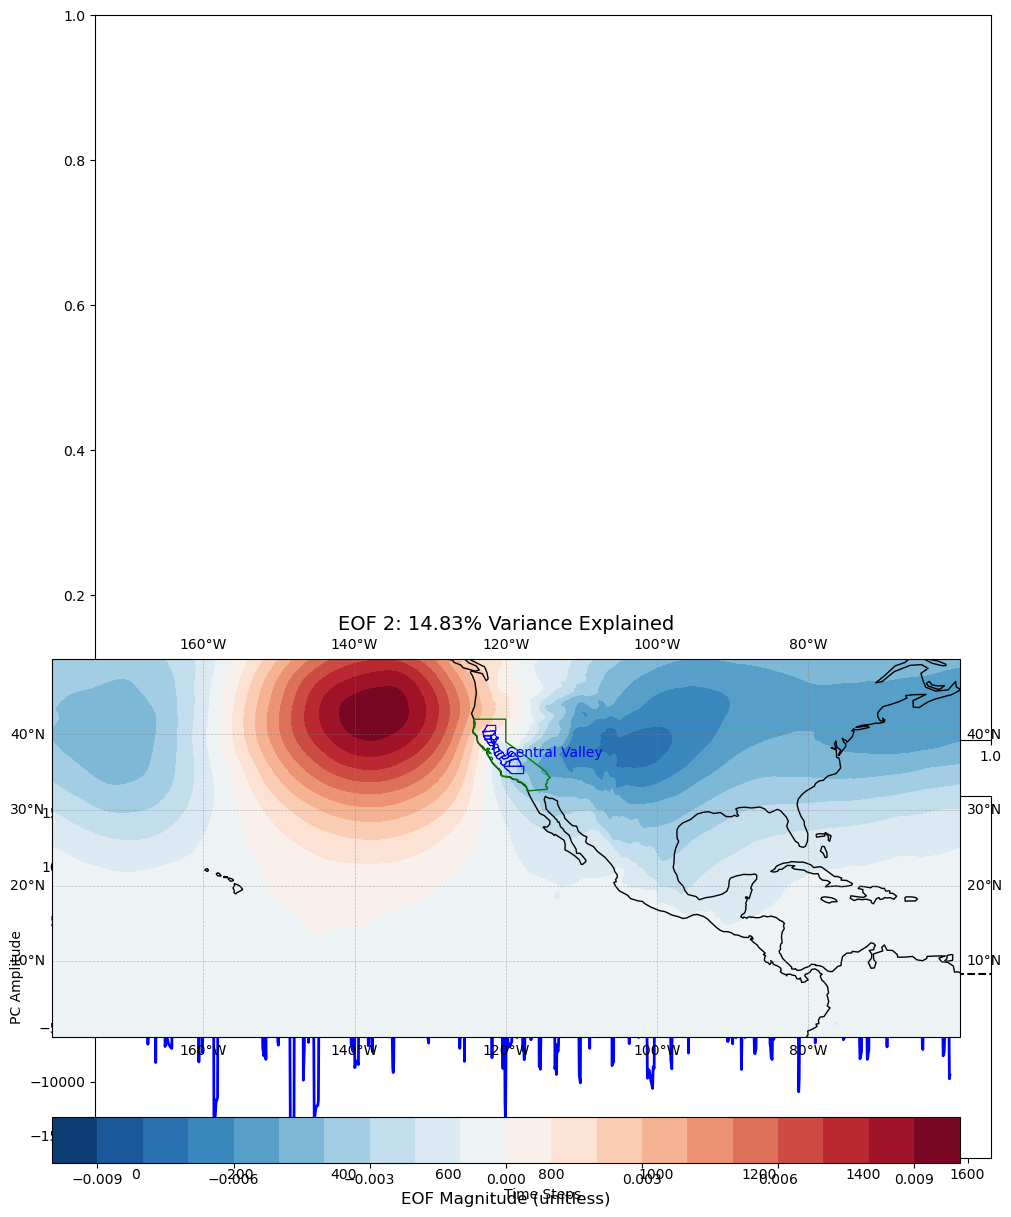

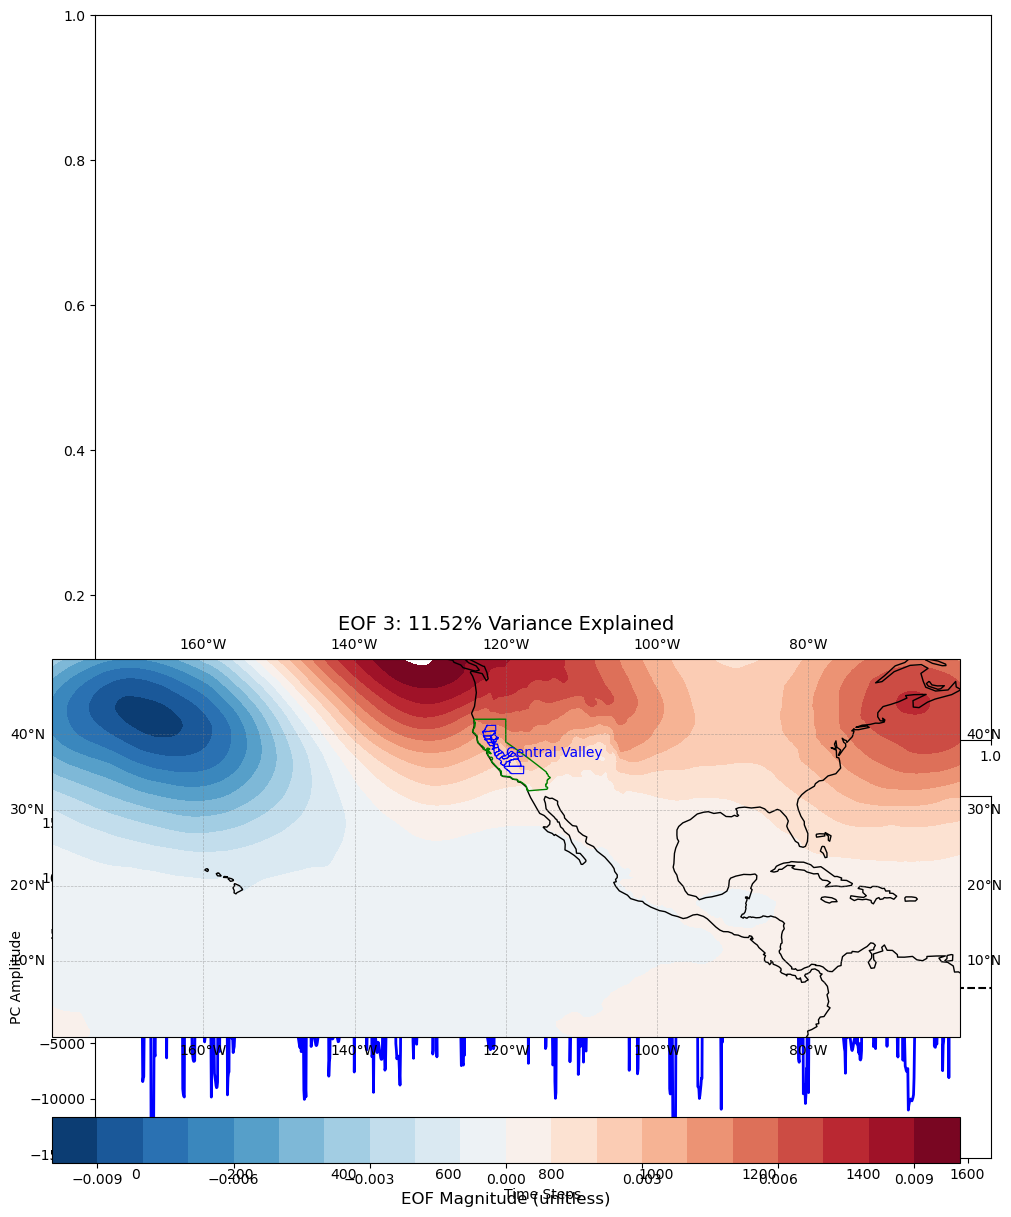

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")

# Calculate anomalies
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Restrict anomalies to specific coordinates
lat = climatology['latitude'].values
lon = climatology['longitude'].values
lon_mask = (lon >= -180) & (lon <= -60)
lat_mask = (lat >= 0) & (lat <= 50)

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

anomalies_restricted = anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Prepare data for EOF analysis
# Assume 'z' is the variable for geopotential height
data = anomalies_restricted['z']

# Reduce data to 3D (time, lat, lon) by removing extra dimensions
if 'pressure_level' in data.dims:
    data = data.mean(dim='pressure_level')  # Average over pressure levels

# Compute time-mean anomalies and remove the mean
time_mean = data.mean(dim='valid_time')
anomalies_centered = data - time_mean

# Convert anomalies to a NumPy array for EOF analysis
anomalies_np = anomalies_centered.values  # Shape: (time, lat, lon)

# Flatten spatial dimensions for EOF calculation
n_times, n_lat, n_lon = anomalies_np.shape
data_flat = anomalies_np.reshape(n_times, n_lat * n_lon)

# Apply square-root cosine latitude weights
coslat = np.cos(np.deg2rad(lat_restricted))  # Shape: (lat,)
coslat_2d = np.repeat(coslat[:, np.newaxis], n_lon, axis=1)  # Expand to (lat, lon)
wgts = np.sqrt(coslat_2d).flatten()  # Flatten to match spatial dimensions of data_flat

# Initialize EOF solver with weights
solver = Eof(data_flat, weights=wgts)

# Retrieve the leading EOFs, PCs, and explained variance
eof_modes_flat = solver.eofs(neofs=3)  # Flattened EOFs
pcs = solver.pcs(npcs=3, pcscaling=0)  # Principal components
variance_fraction = solver.varianceFraction()

# Reshape EOFs back to spatial dimensions
eof_modes = eof_modes_flat.reshape(3, n_lat, n_lon)  # (modes, lat, lon)

# Define Central Valley shapefile
california_shapefile = "california_shapefile.shp"  # Replace with actual path
central_valley_shapefile = "central_valley_counties.shp"  # Replace with actual path

# Plot the leading EOFs with improvements
for i in range(3):  # Plot EOFs 1-3
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [2, 1]}, constrained_layout=True
    )

    # Plot EOF map
    ax1 = plt.axes(projection=ccrs.PlateCarree())
    ax1.coastlines(resolution='110m')
    ax1.add_feature(ShapelyFeature(Reader(california_shapefile).geometries(),
                                    ccrs.PlateCarree(), edgecolor='green', facecolor='none', linewidth=1))
    ax1.add_feature(ShapelyFeature(Reader(central_valley_shapefile).geometries(),
                                    ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linewidth=0.8))

    ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    fill = ax1.contourf(
        lon_restricted,
        lat_restricted,
        eof_modes[i, :, :],
        levels=np.linspace(-0.01, 0.01, 21),  # Customize levels
        cmap='RdBu_r',
        transform=ccrs.PlateCarree(),
    )
    cb = plt.colorbar(fill, orientation='horizontal', pad=0.05, ax=ax1)
    cb.set_label("EOF Magnitude (unitless)", fontsize=12)
    cb.ax.tick_params(labelsize=10)
    ax1.set_title(f"EOF {i + 1}: {variance_fraction[i] * 100:.2f}% Variance Explained", fontsize=14)

    # Add annotations for Central Valley
    ax1.text(-120, 37, "Central Valley", fontsize=10, color="blue", transform=ccrs.PlateCarree())

    # Plot Principal Component (PC)
    ax2.plot(range(len(pcs[:, i])), pcs[:, i], color='blue', linewidth=2)
    ax2.axhline(0, color='black', linestyle='--')
    ax2.set_title(f"Principal Component {i + 1} Time Series", fontsize=12)
    ax2.set_xlabel("Time Steps")
    ax2.set_ylabel("PC Amplitude")

    # Save plot
    plt.savefig(f"eof_{i + 1}_with_pc.png", dpi=300, bbox_inches="tight")
    plt.show()


/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


TypeError: GeoAxes.quiver() missing 2 required positional arguments: 'u' and 'v'

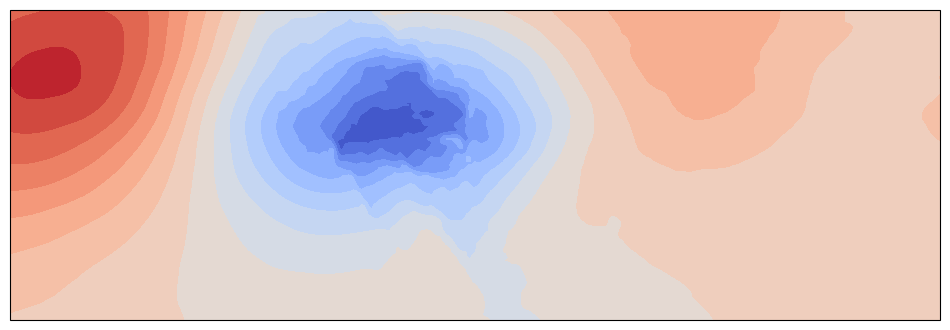

In [27]:
# Import necessary libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from scipy.stats import ttest_ind

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u850_dust = xr.open_dataset("u850_dust.nc")
v850_dust = xr.open_dataset("v850_dust.nc")
u_clim = xr.open_dataset("u_clim.nc")
v_clim = xr.open_dataset("v_clim.nc")

# Adjust dimension names if necessary
if 'valid_time' in climatology.dims:
    climatology = climatology.rename({'valid_time': 'time'})
if 'valid_time' in dust_event.dims:
    dust_event = dust_event.rename({'valid_time': 'time'})

# Calculate anomalies for the dust event dates
anomalies = (dust_event / 9.8) - (climatology / 9.8)

# Take the mean of the anomalies across all dust event time steps
mean_anomalies = anomalies.mean(dim="time")

# Extract latitude and longitude
lat = climatology['latitude'].values
lon = climatology['longitude'].values

# Restrict data to specific coordinates
lon_mask = (lon >= -150) & (lon <= -60)  # Longitude range
lat_mask = (lat >= 20) & (lat <= 50)  # Latitude range

lon_restricted = lon[lon_mask]
lat_restricted = lat[lat_mask]

mean_anomalies_restricted = mean_anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

# Reduce the 3D anomalies to 2D by selecting or averaging over the pressure_level
if 'pressure_level' in mean_anomalies_restricted.dims:
    mean_anomalies_2d = mean_anomalies_restricted['z'].mean(dim='pressure_level')
else:
    mean_anomalies_2d = mean_anomalies_restricted['z']

# Perform a t-test for statistical significance
t_stat, p_values = ttest_ind(
    dust_event['z'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='pressure_level').values,
    climatology['z'].sel(latitude=lat_restricted, longitude=lon_restricted).mean(dim='pressure_level').values,
    axis=0,
    equal_var=False,
    nan_policy='omit'
)

# Define significance level
significance_level = 0.05
significant_mask = p_values < significance_level

# Ensure significant_mask is 2D
if significant_mask.ndim == 3:  # Reduce dimensionality if needed
    significant_mask_2d = significant_mask.mean(axis=0)
else:
    significant_mask_2d = significant_mask

# Calculate wind anomalies
u_anomalies = u850_dust - u_clim
v_anomalies = v850_dust - v_clim

# Check and rename 'valid_time' to 'time' for consistency
if 'valid_time' in u_anomalies.dims:
    u_anomalies = u_anomalies.rename({'valid_time': 'time'})
if 'valid_time' in v_anomalies.dims:
    v_anomalies = v_anomalies.rename({'valid_time': 'time'})

# Take the mean of wind anomalies over the correct time dimension
u_mean_anomalies = u_anomalies.mean(dim="time")
v_mean_anomalies = v_anomalies.mean(dim="time")

# Extract numpy arrays for t-test
t_stat_u, p_values_u = ttest_ind(
    u850_dust['u'].values,  # Ensure numerical data
    u_clim['u'].values,
    axis=0,
    equal_var=False,
    nan_policy='omit'
)
t_stat_v, p_values_v = ttest_ind(
    v850_dust['v'].values,  # Ensure numerical data
    v_clim['v'].values,
    axis=0,
    equal_var=False,
    nan_policy='omit'
)

# Define significance level
u_significant = p_values_u < significance_level
v_significant = p_values_v < significance_level

# Restrict wind anomalies to specific coordinates
u_mean_anomalies_restricted = u_mean_anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)
v_mean_anomalies_restricted = v_mean_anomalies.sel(latitude=lat_restricted, longitude=lon_restricted)

lat_indices = np.where(lat_mask)[0]
lon_indices = np.where(lon_mask)[0]
u_significant = np.reshape(u_significant, (lat.size, lon.size))
u_significant_restricted = u_significant[lat_mask][:, lon_mask]
v_significant = np.reshape(v_significant, (lat.size, lon.size))
v_significant_restricted = v_significant[lat_mask][:, lon_mask]

# Create a meshgrid for the restricted region
lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)

# Plot the composite anomalies
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))
ax.set_extent([-150, -60, 20, 50], crs=ccrs.PlateCarree())

# Plot anomalies (2D array)
anomaly_plot = ax.contourf(
    lon2d,
    lat2d,
    mean_anomalies_2d,
    levels=20,
    cmap='coolwarm',
    transform=ccrs.PlateCarree(),
)

# Overlay significant areas
ax.contourf(
    lon2d,
    lat2d,
    significant_mask_2d.astype(int),
    levels=[0.5, 1],
    colors='none',
    hatches=['..'],
    transform=ccrs.PlateCarree(),
)

# Add quiver plot for wind anomalies
u_quiver = u_mean_anomalies_restricted['u'].values[::5, ::5]
v_quiver = v_mean_anomalies_restricted['v'].values[::5, ::5]

quiver = ax.quiver(
    lon2d[::5, ::5], lat2d[::5, ::5],
    transform=ccrs.PlateCarree(),
    color="black", scale=500, regrid_shape=20, width=0.0025
)

# Overlay significant quivers in green
significant_u = u_mean_anomalies_restricted[::5, ::5] * u_significant_restricted[::5, ::5]
significant_v = v_mean_anomalies_restricted[::5, ::5] * v_significant_restricted[::5, ::5]
ax.quiver(
    lon2d[::5, ::5], lat2d[::5, ::5],
    significant_u, significant_v,
    transform=ccrs.PlateCarree(),
    color="green", scale=500, regrid_shape=20, width=0.0025
)

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Add California and Central Valley shapefiles
california_shapefile = "california_shapefile.shp"  # Replace with the path to the shapefile
central_valley_shapefile = "central_valley_counties.shp"  # Replace with the path to the shapefile

california_feature = ShapelyFeature(
    Reader(california_shapefile).geometries(),
    ccrs.PlateCarree(),
    edgecolor='green',
    facecolor='none',
    linewidth=1,
)
ax.add_feature(california_feature)

central_valley_feature = ShapelyFeature(
    Reader(central_valley_shapefile).geometries(),
    ccrs.PlateCarree(),
    edgecolor='black',
    facecolor='none',
    linewidth=0.5,
)
ax.add_feature(central_valley_feature)

# Add gridlines with labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

# Add title and colorbar
ax.set_title("Composite Anomalies and Wind Anomalies for Dust Events")
cbar = fig.colorbar(anomaly_plot, ax=ax, orientation='horizontal', pad=0.05, label="Geopotential Height Anomaly (m)")

plt.show()


Anomalies shape: (201, 481)


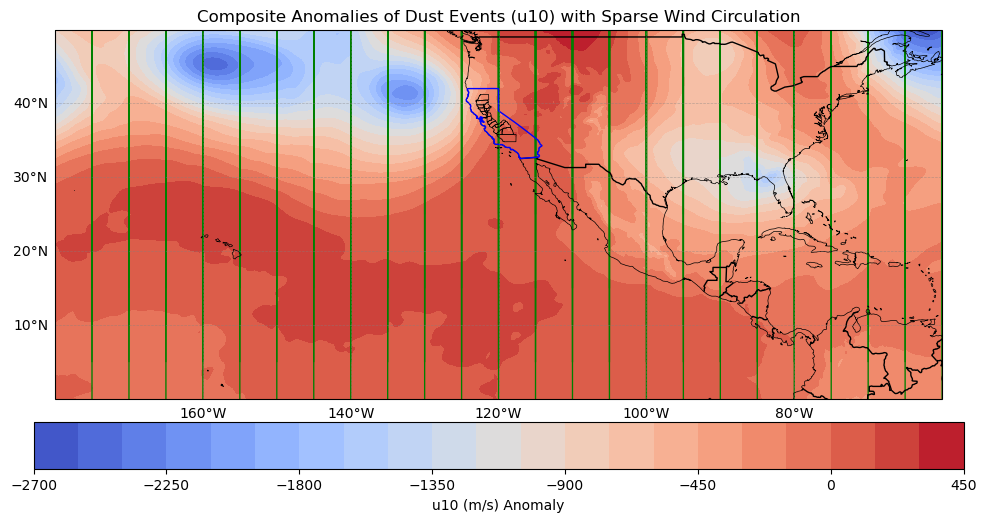

In [46]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load datasets
climatology = xr.open_dataset("clim.nc")
dust_event = xr.open_dataset("dust-composite2.nc")
u_wind_data = xr.open_dataset("u850_dust2.nc")
v_wind_data = xr.open_dataset("v850_dust2.nc")

# Since latitude is from 50 down to 0, use slice(50,0)
lat_slice = slice(50, 0)
lon_slice = slice(-180, -60)

climatology_sel = climatology.sel(latitude=lat_slice, longitude=lon_slice)
dust_event_sel = dust_event.sel(latitude=lat_slice, longitude=lon_slice)
u_wind_sel = u_wind_data.sel(latitude=lat_slice, longitude=lon_slice)
v_wind_sel = v_wind_data.sel(latitude=lat_slice, longitude=lon_slice)

# Extract variable 'z'
climatology_var = climatology_sel['z']
dust_event_var = dust_event_sel['z']

# Remove any extra dims if present, but from your printout it seems you already have latitude/longitude only
# If needed, select time or pressure_level indexes:
if 'valid_time' in dust_event_var.dims:
    dust_event_var = dust_event_var.isel(valid_time=0)
if 'pressure_level' in dust_event_var.dims:
    dust_event_var = dust_event_var.isel(pressure_level=0)

if 'valid_time' in climatology_var.dims:
    climatology_var = climatology_var.isel(valid_time=0)
if 'pressure_level' in climatology_var.dims:
    climatology_var = climatology_var.isel(pressure_level=0)

# Compute anomalies
anomalies = dust_event_var - climatology_var

# Now anomalies should have a shape with a non-zero latitude dimension
print("Anomalies shape:", anomalies.shape)  # Expect something like (N_lat, N_lon), with N_lat > 0

lon2d, lat2d = np.meshgrid(anomalies.longitude, anomalies.latitude)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))
ax.set_extent([-180, -60, 0, 50], crs=ccrs.PlateCarree())

anomaly_plot = ax.contourf(lon2d, lat2d, anomalies.values, levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())

# Handle wind data similarly (select first valid_time/pressure_level if needed)
u_wind = u_wind_sel['u']
v_wind = v_wind_sel['v']
if 'valid_time' in u_wind.dims:
    u_wind = u_wind.isel(valid_time=0)
if 'pressure_level' in u_wind.dims:
    u_wind = u_wind.isel(pressure_level=0)
if 'valid_time' in v_wind.dims:
    v_wind = v_wind.isel(valid_time=0)
if 'pressure_level' in v_wind.dims:
    v_wind = v_wind.isel(pressure_level=0)

quiver_spacing = 20
ax.quiver(lon2d[::quiver_spacing, ::quiver_spacing],
          lat2d[::quiver_spacing, ::quiver_spacing],
          u_wind.values[::quiver_spacing, ::quiver_spacing],
          v_wind.values[::quiver_spacing, ::quiver_spacing],
          scale=200, transform=ccrs.PlateCarree(), color='green', width=0.0015)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

california_shapefile = "california_shapefile.shp"
central_valley_shapefile = "central_valley_counties.shp"

california_feature = ShapelyFeature(Reader(california_shapefile).geometries(),
                                    ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linewidth=1)
ax.add_feature(california_feature)

central_valley_feature = ShapelyFeature(Reader(central_valley_shapefile).geometries(),
                                        ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.5)
ax.add_feature(central_valley_feature)

gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

ax.set_title("Composite Anomalies of Dust Events (u10) with Sparse Wind Circulation")
cbar = fig.colorbar(anomaly_plot, ax=ax, orientation='horizontal', pad=0.05, label="u10 (m/s) Anomaly")

plt.show()
